# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.station_embedding import learn_station_embeddings, attach_station_embedding
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]
#STATION_IDS = [211, 212, 213, 214, 216]
#STATION_IDS = [211, 212, 213, 216]

CMAQDATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station"

PM_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "SO2_quantrac"
]

CMAQ_COLS = [
    "NO2_cmaq",
    "O3_cmaq",
    "SO2_cmaq"
]

BASE_FEATURE_COLS = PM_COLS + CMAQ_COLS

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24, 48, 72]
ROLL_WINDOWS = [3, 6, 12, 24, 48, 72]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

'''
# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")
'''

# Store the results in one directory only, for testing API purpose
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/so2_pmcmaqdata_test_models"
if os.path.isdir(LIGHTGBM_DIR):
    import shutil
    shutil.rmtree(LIGHTGBM_DIR)
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/so2_pmcmaqdata_test_models


# Load dataset

## Method

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
    elif "Date" in df.columns and "Time" in df.columns:
        df["date"] = pd.to_datetime((df["Date"] + " " + df["Time"]).astype('datetime64[ns]'), format="%y/%m/%d %H:%M:%S")
        df = df.drop(columns=["Date", "Time"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove "Unnamed" column
    for c in df.columns:
        if "Unnamed:" in c:
            df = df.drop(columns=[c])

    # Add station_id column
    if "Station" not in df.columns:
        df["station_id"] = station_id
    else:
        df = df.rename({"Station": "station_id"}, axis=1)
    return df

## CMAQ data

In [3]:
# Load dataset
dfs_cmaq = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, CMAQDATA_DIR)
    dfs_cmaq.append(df_sid)
df_cmaq = pd.concat(dfs_cmaq, ignore_index=True)

# Rename columns
df_cmaq = df_cmaq.rename({c: f"{c}_cmaq" for c in df_cmaq.columns if c not in ["date", "station_id"]}, axis=1)

# Sort data by station then date
df_cmaq = df_cmaq.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_cmaq = df_cmaq.loc[:, ["date"] + CMAQ_COLS + ["station_id"]]

display(df_cmaq)

# Convert unit
df_cmaq["NO2_cmaq"] = df_cmaq["NO2_cmaq"] * 1883.2
df_cmaq["O3_cmaq"] = df_cmaq["O3_cmaq"] * 1960
df_cmaq["SO2_cmaq"] = df_cmaq["SO2_cmaq"] * 2620

print(df_cmaq.shape)
print(df_cmaq.columns)
df_cmaq

date  NO2_cmaq   O3_cmaq  SO2_cmaq  station_id
0     2022-01-01 07:00:00  0.000072  0.096425  0.000027         211
1     2022-01-01 08:00:00  0.000074  0.077419  0.000038         211
2     2022-01-01 09:00:00  0.000055  0.061006  0.000050         211
3     2022-01-01 10:00:00  0.000040  0.048525  0.000057         211
4     2022-01-01 11:00:00  0.000034  0.029449  0.000047         211
...                   ...       ...       ...       ...         ...
44851 2022-12-31 01:00:00  0.002276  0.026421  0.000149         216
44852 2022-12-31 02:00:00  0.002208  0.026171  0.000148         216
44853 2022-12-31 03:00:00  0.002249  0.026087  0.000151         216
44854 2022-12-31 04:00:00  0.002680  0.026347  0.000166         216
44855 2022-12-31 05:00:00  0.002590  0.026102  0.000164         216

[44856 rows x 5 columns]

(44856, 5)
Index(['date', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq', 'station_id'], dtype='object')


date  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id
0     2022-01-01 07:00:00  0.136344  188.993157  0.071526         211
1     2022-01-01 08:00:00  0.138604  151.741122  0.100084         211
2     2022-01-01 09:00:00  0.104141  119.571595  0.130476         211
3     2022-01-01 10:00:00  0.075893   95.109490  0.149078         211
4     2022-01-01 11:00:00  0.063087   57.721016  0.122092         211
...                   ...       ...         ...       ...         ...
44851 2022-12-31 01:00:00  4.285888   51.784937  0.389183         216
44852 2022-12-31 02:00:00  4.157322   51.295325  0.386550         216
44853 2022-12-31 03:00:00  4.235773   51.130547  0.394695         216
44854 2022-12-31 04:00:00  5.047855   51.640614  0.435544         216
44855 2022-12-31 05:00:00  4.876919   51.160312  0.429932         216

[44856 rows x 5 columns]

## PM data

In [4]:
# Load dataset
dfs_pm = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs_pm.append(df_sid)
df_pm = pd.concat(dfs_pm, ignore_index=True)

# Sort data by station then date
df_pm = df_pm.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_pm = df_pm.loc[:, ["date"] + PM_COLS + ["station_id"]]

print(df_pm.shape)
print(df_pm.columns)
df_pm

(92966, 7)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'station_id'],
      dtype='object')


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2021-02-23 21:00:00    112.740762      15.604762    55.431381   
1     2021-02-23 22:00:00    112.366471      14.594118    58.197176   
2     2021-02-23 23:00:00    112.700433      13.436667    55.029433   
3     2021-02-24 00:00:00    112.480867      12.365000    54.767700   
4     2021-02-24 01:00:00    114.331500      11.636667    53.786200   
...                   ...           ...            ...          ...   
92961 2022-12-31 19:00:00      0.088233      41.450000    75.916667   
92962 2022-12-31 20:00:00      0.083217      50.530000    66.116667   
92963 2022-12-31 21:00:00      0.084300      55.055000    55.133333   
92964 2022-12-31 22:00:00      0.066650      26.078333    46.750000   
92965 2022-12-31 23:00:00      0.067783      21.161667    50.016667   

       CO_quantrac  SO2_quantrac  station_id  
0        90.000000           NaN         211  
1      1200.603529           NaN         211  
2      1177.897000           NaN         211  
3        90.000000           NaN         211  
4        90.000000           NaN         211  
...            ...           ...         ...  
92961     2.087167      0.105667         216  
92962     2.006500      0.104167         216  
92963     2.418833      0.130167         216  
92964     1.481500      0.075833         216  
92965     1.301167      0.060833         216  

[92966 rows x 7 columns]

## Merge 2 data

In [5]:
dfs_all = []
for station in STATION_IDS:
    df_pm_station = df_pm[df_pm["station_id"] == station]
    df_cmaq_station = df_cmaq[df_cmaq["station_id"] == station]
    df_joined = pd.merge(df_pm_station.drop(columns=["station_id"]), df_cmaq_station, on='date', how='inner')
    dfs_all.append(df_joined)
df_all = pd.concat(dfs_all, axis=0).reset_index(drop=True)
df_all

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 07:00:00     90.000000      22.783333    35.588975   
1     2022-01-01 08:00:00     90.000000      21.883333    55.011077   
2     2022-01-01 09:00:00     90.000000      16.233333    64.729197   
3     2022-01-01 10:00:00     90.000000      15.700000    75.109218   
4     2022-01-01 11:00:00     74.207348      15.650000    77.767804   
...                   ...           ...            ...          ...   
43370 2022-12-31 01:00:00      0.049037      17.709259    31.425926   
43371 2022-12-31 02:00:00      0.063288      22.803390    43.220339   
43372 2022-12-31 03:00:00      0.069050      23.031667    48.866667   
43373 2022-12-31 04:00:00      0.064600      22.331667    50.633333   
43374 2022-12-31 05:00:00      0.064517      20.108333    52.333333   

       CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  
0       756.627400           NaN  0.136344  188.993157  0.071526         211  
1       749.102000           NaN  0.138604  151.741122  0.100084         211  
2       727.519000           NaN  0.104141  119.571595  0.130476         211  
3       721.196900           NaN  0.075893   95.109490  0.149078         211  
4       722.056400           NaN  0.063087   57.721016  0.122092         211  
...            ...           ...       ...         ...       ...         ...  
43370     0.824074      0.031852  4.285888   51.784937  0.389183         216  
43371     0.717627      0.024746  4.157322   51.295325  0.386550         216  
43372     0.746167      0.026167  4.235773   51.130547  0.394695         216  
43373     0.617667      0.020333  5.047855   51.640614  0.435544         216  
43374     0.621500      0.015000  4.876919   51.160312  0.429932         216  

[43375 rows x 10 columns]

In [6]:
df_all.isnull().sum()

date                 0
NO2_quantrac     27391
PM25_quantrac    27393
O3_quantrac      30277
CO_quantrac      27407
SO2_quantrac     28944
NO2_cmaq             0
O3_cmaq              0
SO2_cmaq             0
station_id           0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [7]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 07:00:00      0.038383      25.058333    48.800000   
1     2022-01-01 08:00:00      0.036102      26.491837    51.408163   
2     2022-01-01 09:00:00      0.033818      29.060000    54.545455   
3     2022-01-01 10:00:00      0.023833      28.475000    51.500000   
4     2022-01-01 11:00:00      0.015467      21.743333    44.300000   
...                   ...           ...            ...          ...   
11516 2022-12-31 01:00:00      0.049037      17.709259    31.425926   
11517 2022-12-31 02:00:00      0.063288      22.803390    43.220339   
11518 2022-12-31 03:00:00      0.069050      23.031667    48.866667   
11519 2022-12-31 04:00:00      0.064600      22.331667    50.633333   
11520 2022-12-31 05:00:00      0.064517      20.108333    52.333333   

       CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  
0         0.835000      0.044167  2.014461  191.530965  0.087508         214  
1         0.846531      0.041224  1.793782  144.585143  0.129166         214  
2         0.948182      0.043091  1.255505  116.822409  0.167680         214  
3         0.877667      0.037500  0.910386   96.557955  0.184186         214  
4         0.666500      0.031000  0.788758   77.925827  0.148554         214  
...            ...           ...       ...         ...       ...         ...  
11516     0.824074      0.031852  4.285888   51.784937  0.389183         216  
11517     0.717627      0.024746  4.157322   51.295325  0.386550         216  
11518     0.746167      0.026167  4.235773   51.130547  0.394695         216  
11519     0.617667      0.020333  5.047855   51.640614  0.435544         216  
11520     0.621500      0.015000  4.876919   51.160312  0.429932         216  

[11521 rows x 10 columns]

## Update the STATION_IDS after dropping missing

In [8]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[214, 216]

## Visualization

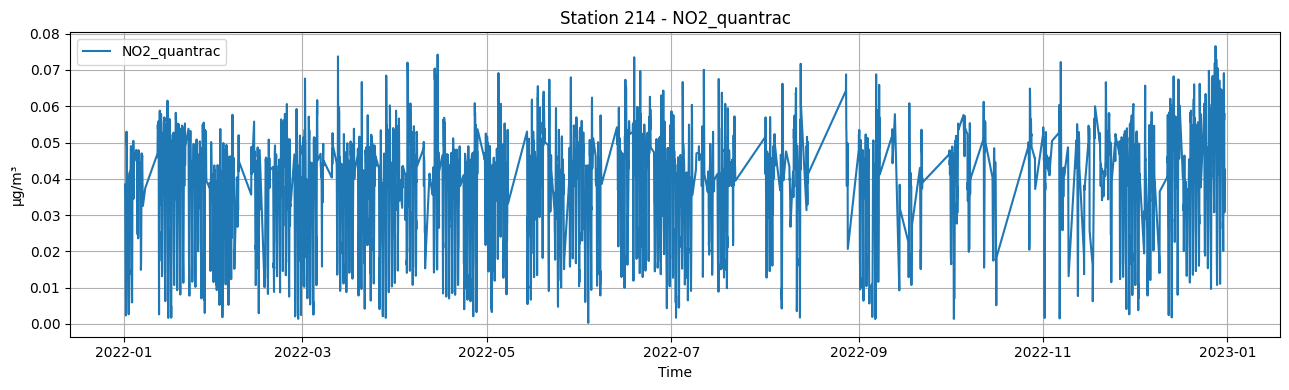

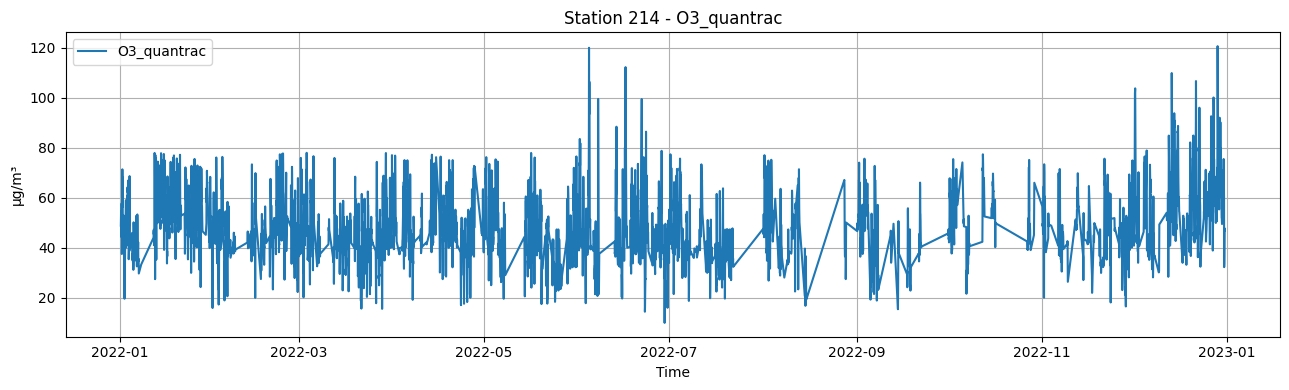

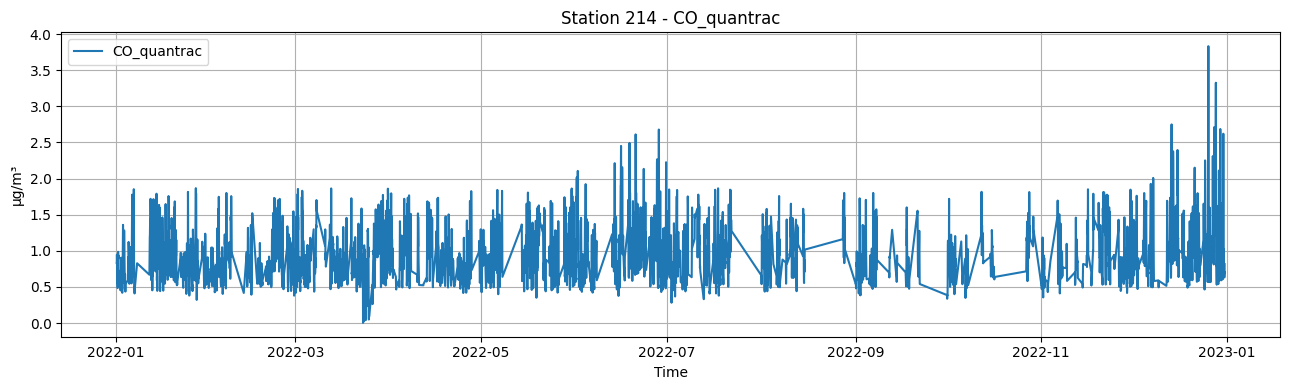

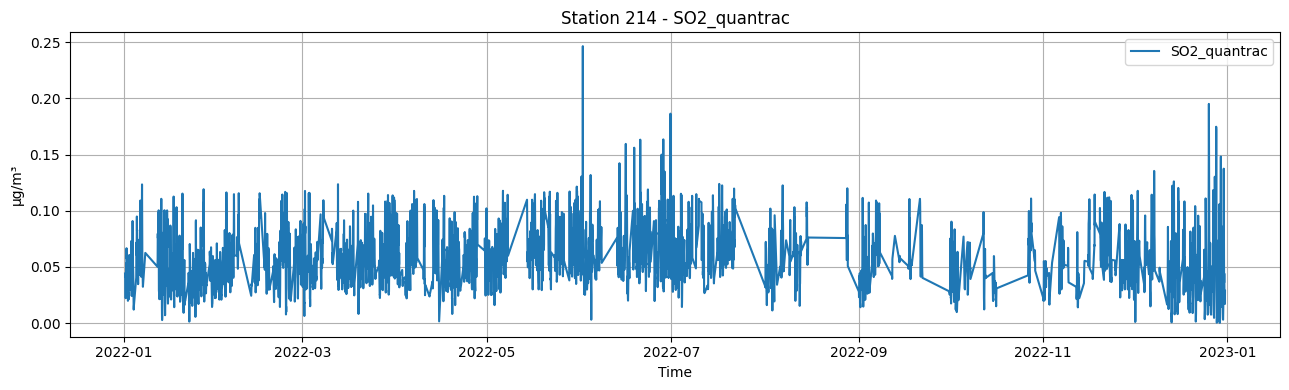

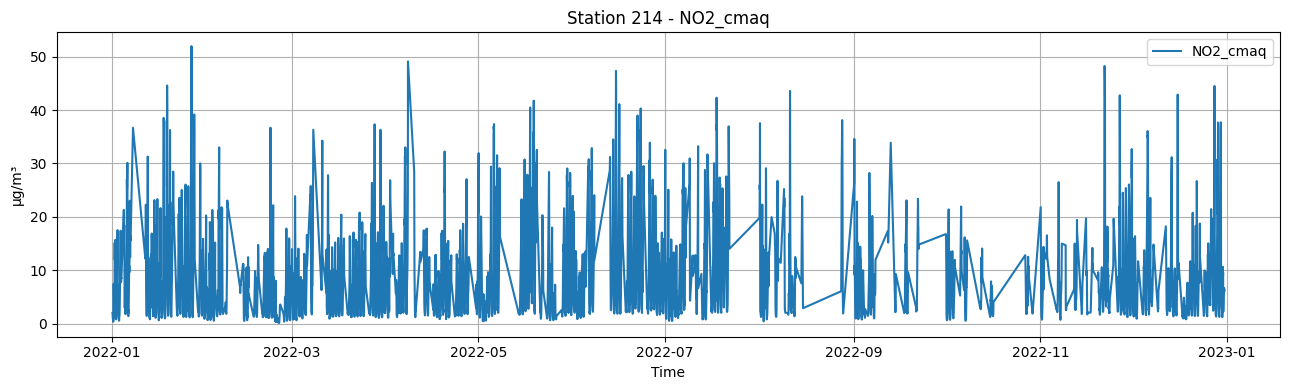

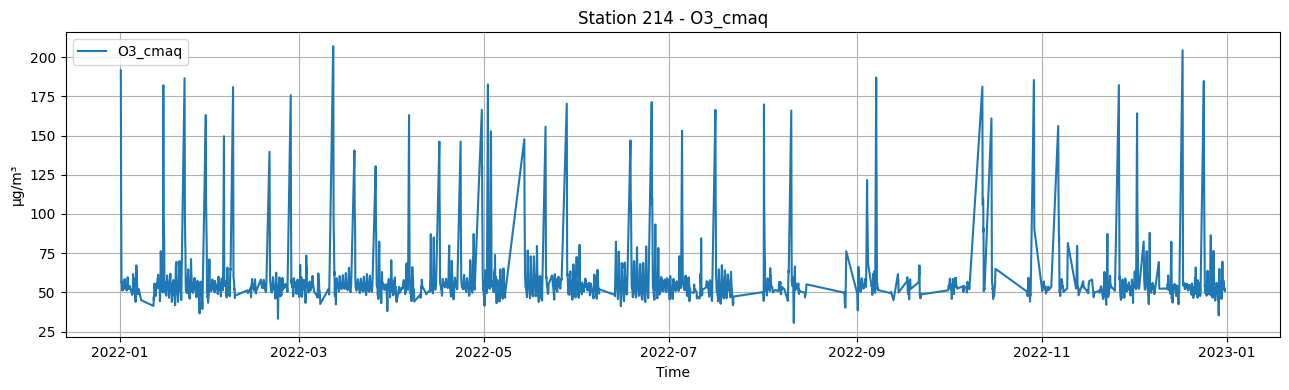

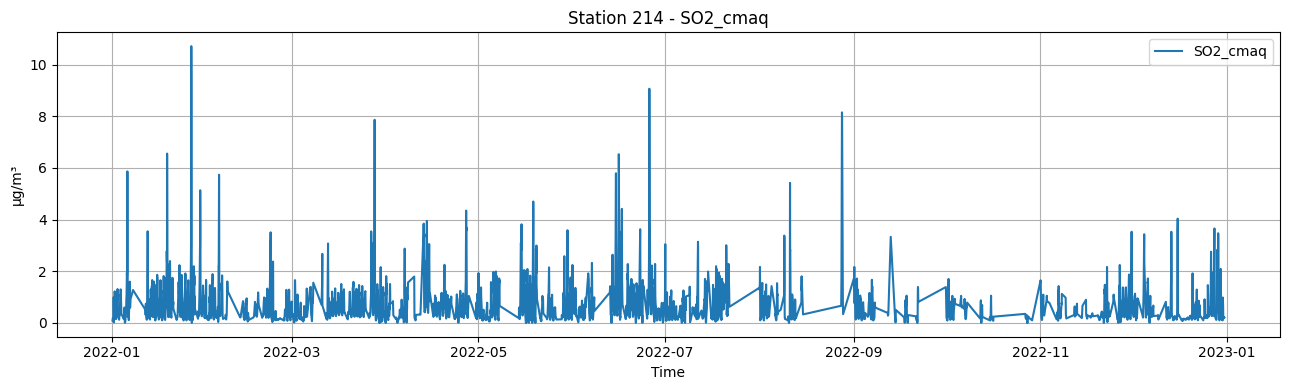

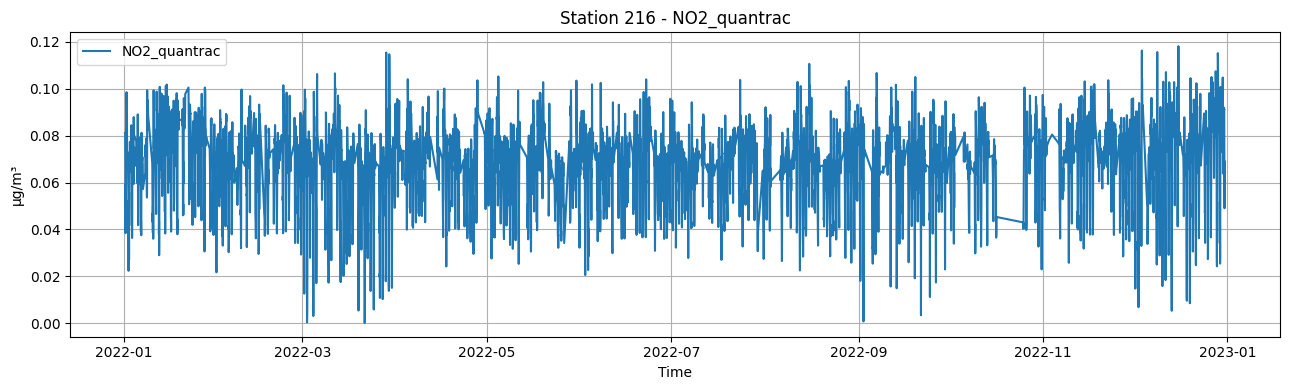

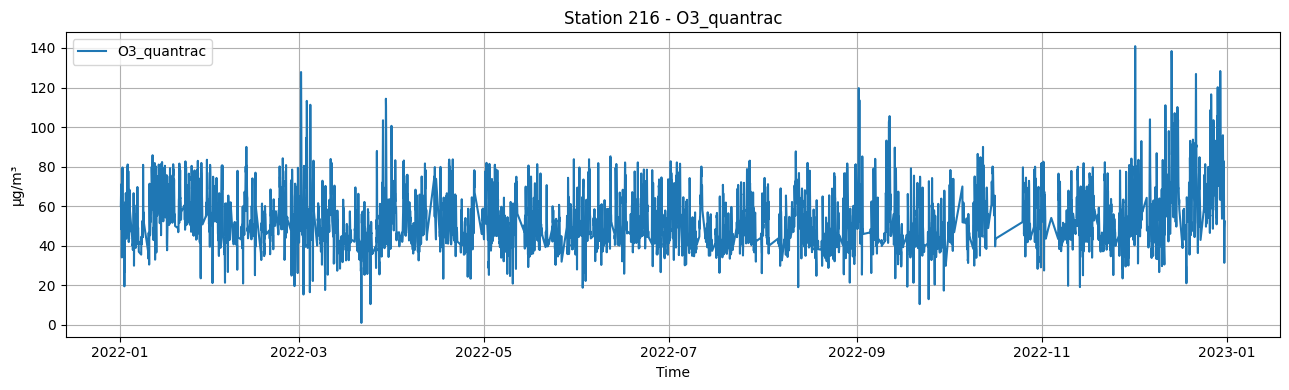

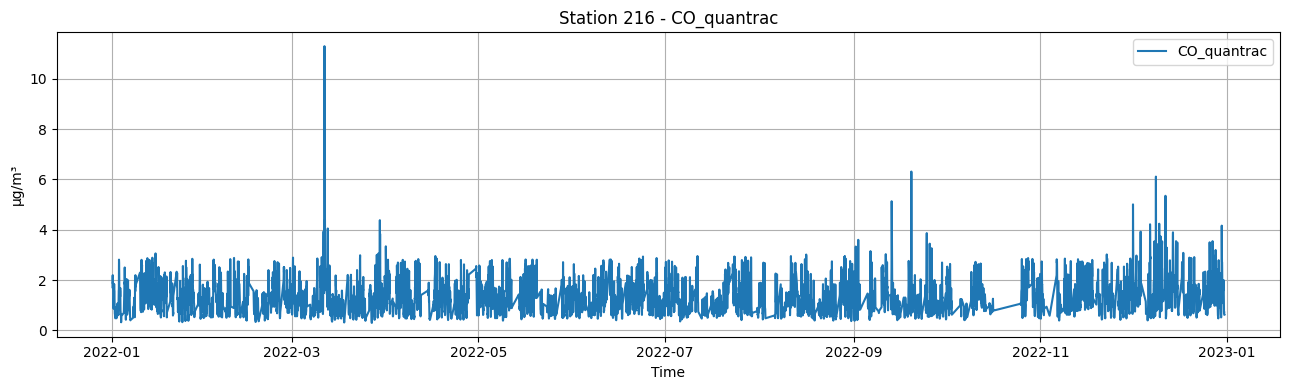

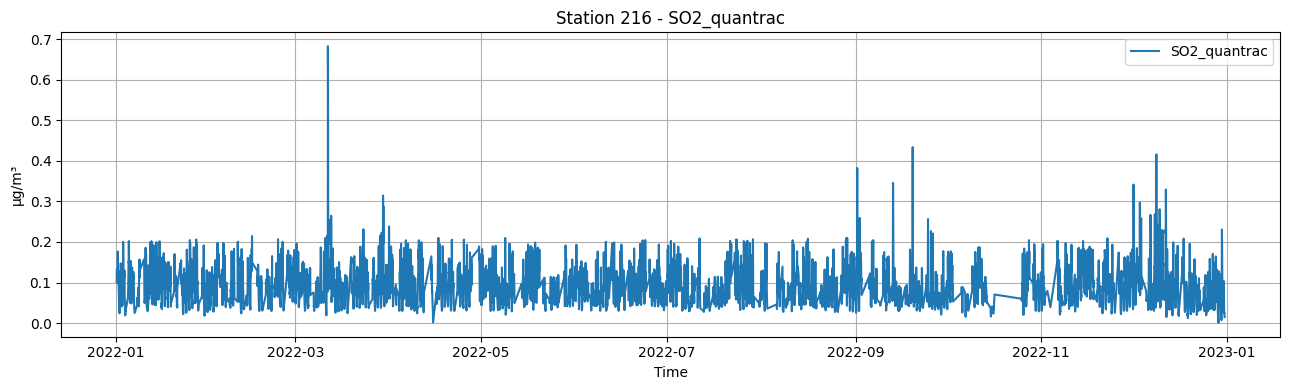

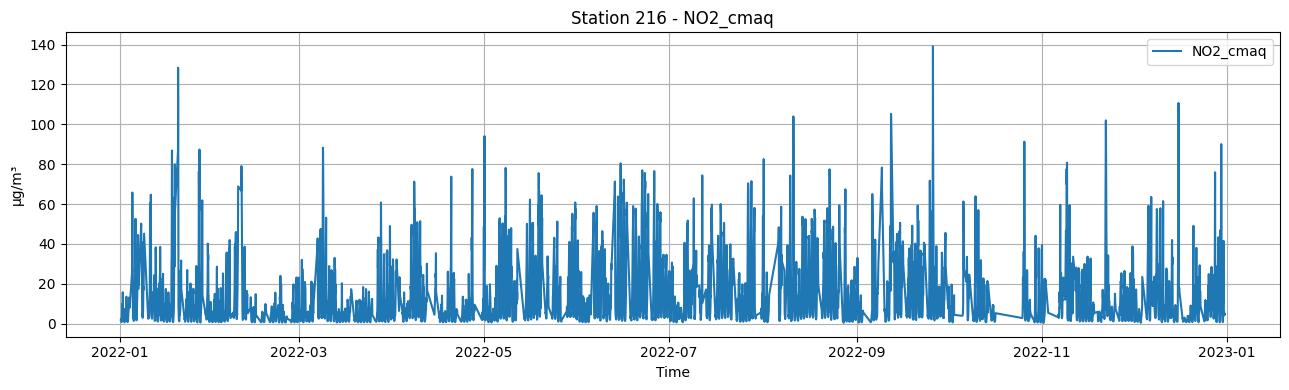

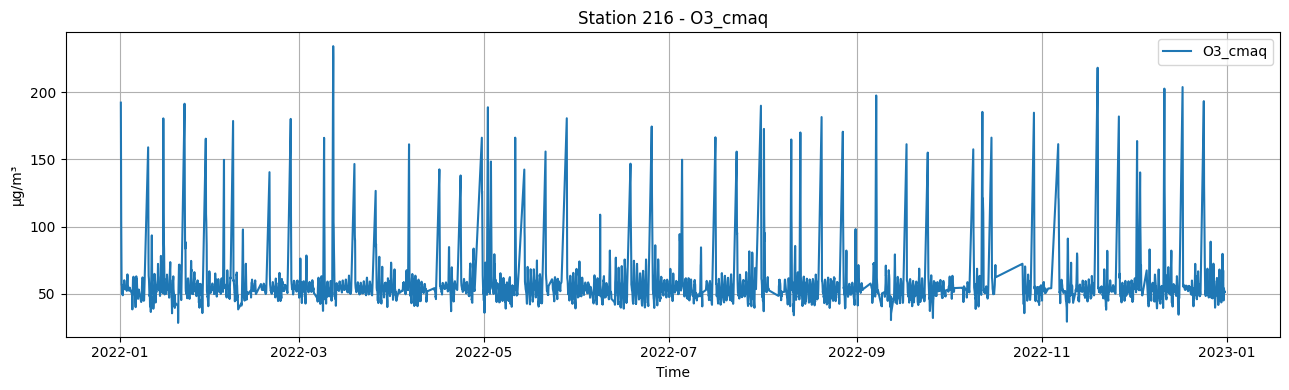

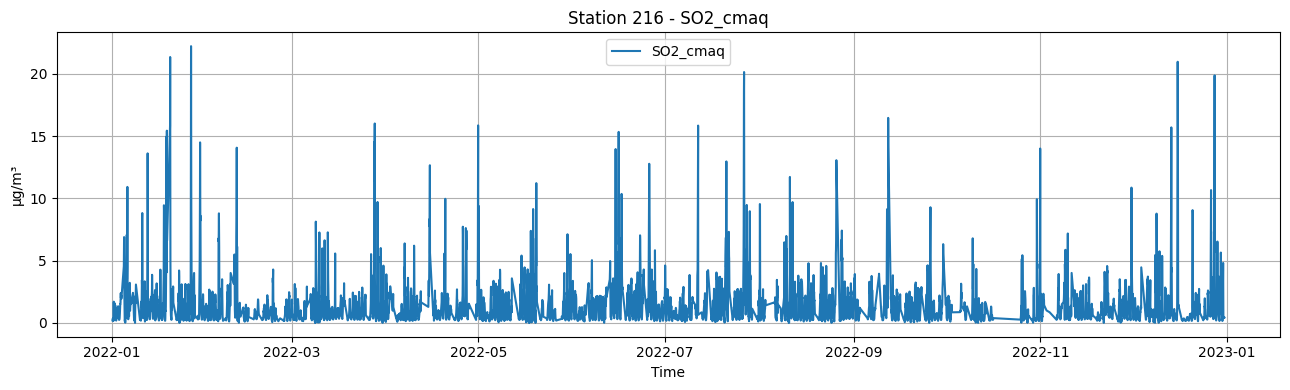

In [9]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [10]:
df_converted = copy.deepcopy(df_dropped)
#mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")

print("=" * 50 + "BEFORE" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

#mask_no2 = (df_converted["NO2_quantrac"] < 1.0)
#df_converted.loc[mask_no2, "NO2_quantrac"] = df_converted.loc[mask_no2, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[:, "NO2_quantrac"] = df_converted.loc[:, "NO2_quantrac"].apply(lambda x: x * 1883.2)

#mask_co = (df_converted["CO_quantrac"] < 1.0)
#df_converted.loc[mask_co, "CO_quantrac"] = df_converted.loc[mask_co, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted.loc[:, "CO_quantrac"] = df_converted.loc[:, "CO_quantrac"].apply(lambda x: x * 1146.8)

#mask_so2 = (df_converted["SO2_quantrac"] < 1.0)
#df_converted.loc[mask_so2, "SO2_quantrac"] = df_converted.loc[mask_so2, "SO2_quantrac"].apply(lambda x: x * 2620)
df_converted.loc[:, "SO2_quantrac"] = df_converted.loc[:, "SO2_quantrac"].apply(lambda x: x * 2620)

print("=" * 50 + "AFTER" + "=" * 50)
for station in STATION_IDS:
    display(df_converted[df_converted["station_id"] == station])

'''
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted.loc[mask, "SO2_quantrac"] = df_converted.loc[mask, "SO2_quantrac"].apply(lambda x: x * 2620)
df_converted.loc[mask, "SO2_cmaq"] = df_converted.loc[mask, "SO2_cmaq"].apply(lambda x: x * 2620)
df_converted
'''

==================================================BEFORE==================================================


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0    2022-01-01 07:00:00      0.038383      25.058333    48.800000   
1    2022-01-01 08:00:00      0.036102      26.491837    51.408163   
2    2022-01-01 09:00:00      0.033818      29.060000    54.545455   
3    2022-01-01 10:00:00      0.023833      28.475000    51.500000   
4    2022-01-01 11:00:00      0.015467      21.743333    44.300000   
...                  ...           ...            ...          ...   
4836 2022-12-31 01:00:00      0.030850      23.758333    33.866667   
4837 2022-12-31 02:00:00      0.042643      21.983929    40.482143   
4838 2022-12-31 03:00:00      0.037667      20.851667    46.300000   
4839 2022-12-31 04:00:00      0.039800      21.756667    47.716667   
4840 2022-12-31 05:00:00      0.041800      24.283333    46.866667   

      CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  
0        0.835000      0.044167  2.014461  191.530965  0.087508         214  
1        0.846531      0.041224  1.793782  144.585143  0.129166         214  
2        0.948182      0.043091  1.255505  116.822409  0.167680         214  
3        0.877667      0.037500  0.910386   96.557955  0.184186         214  
4        0.666500      0.031000  0.788758   77.925827  0.148554         214  
...           ...           ...       ...         ...       ...         ...  
4836     0.680167      0.027833  6.494761   52.179583  0.190736         214  
4837     0.716786      0.029286  6.616043   51.639454  0.190998         214  
4838     0.631500      0.019833  6.335721   52.246454  0.195452         214  
4839     0.674833      0.017000  6.031225   52.622776  0.204098         214  
4840     0.816333      0.028500  6.428107   51.009764  0.204884         214  

[4841 rows x 10 columns]

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
4841  2022-01-01 07:00:00      0.081167      24.380000    60.100000   
4842  2022-01-01 08:00:00      0.080950      22.648333    63.233333   
4843  2022-01-01 09:00:00      0.077917      22.331667    66.700000   
4844  2022-01-01 10:00:00      0.067467      24.293333    71.166667   
4845  2022-01-01 11:00:00      0.038431      24.360345    53.982759   
...                   ...           ...            ...          ...   
11516 2022-12-31 01:00:00      0.049037      17.709259    31.425926   
11517 2022-12-31 02:00:00      0.063288      22.803390    43.220339   
11518 2022-12-31 03:00:00      0.069050      23.031667    48.866667   
11519 2022-12-31 04:00:00      0.064600      22.331667    50.633333   
11520 2022-12-31 05:00:00      0.064517      20.108333    52.333333   

       CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  
4841      1.716167      0.100833  1.847962  192.197659  0.202002         216  
4842      2.143833      0.128833  2.436309  156.783693  0.274170         216  
4843      2.194833      0.132833  1.949658  125.387982  0.345334         216  
4844      1.860500      0.103667  1.540650  103.125890  0.342248         216  
4845      1.923966      0.124655  1.142447   86.564792  0.235276         216  
...            ...           ...       ...         ...       ...         ...  
11516     0.824074      0.031852  4.285888   51.784937  0.389183         216  
11517     0.717627      0.024746  4.157322   51.295325  0.386550         216  
11518     0.746167      0.026167  4.235773   51.130547  0.394695         216  
11519     0.617667      0.020333  5.047855   51.640614  0.435544         216  
11520     0.621500      0.015000  4.876919   51.160312  0.429932         216  

[6680 rows x 10 columns]

==================================================AFTER==================================================


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0    2022-01-01 07:00:00     72.283493      25.058333    48.800000   
1    2022-01-01 08:00:00     67.987363      26.491837    51.408163   
2    2022-01-01 09:00:00     63.686400      29.060000    54.545455   
3    2022-01-01 10:00:00     44.882933      28.475000    51.500000   
4    2022-01-01 11:00:00     29.126827      21.743333    44.300000   
...                  ...           ...            ...          ...   
4836 2022-12-31 01:00:00     58.096720      23.758333    33.866667   
4837 2022-12-31 02:00:00     80.305029      21.983929    40.482143   
4838 2022-12-31 03:00:00     70.933867      20.851667    46.300000   
4839 2022-12-31 04:00:00     74.951360      21.756667    47.716667   
4840 2022-12-31 05:00:00     78.717760      24.283333    46.866667   

      CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  
0      957.578000    115.716667  2.014461  191.530965  0.087508         214  
1      970.801306    108.008163  1.793782  144.585143  0.129166         214  
2     1087.374909    112.898182  1.255505  116.822409  0.167680         214  
3     1006.508133     98.250000  0.910386   96.557955  0.184186         214  
4      764.342200     81.220000  0.788758   77.925827  0.148554         214  
...           ...           ...       ...         ...       ...         ...  
4836   780.015133     72.923333  6.494761   52.179583  0.190736         214  
4837   822.009857     76.728571  6.616043   51.639454  0.190998         214  
4838   724.204200     51.963333  6.335721   52.246454  0.195452         214  
4839   773.898867     44.540000  6.031225   52.622776  0.204098         214  
4840   936.171067     74.670000  6.428107   51.009764  0.204884         214  

[4841 rows x 10 columns]

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
4841  2022-01-01 07:00:00    152.853067      24.380000    60.100000   
4842  2022-01-01 08:00:00    152.445040      22.648333    63.233333   
4843  2022-01-01 09:00:00    146.732667      22.331667    66.700000   
4844  2022-01-01 10:00:00    127.053227      24.293333    71.166667   
4845  2022-01-01 11:00:00     72.373324      24.360345    53.982759   
...                   ...           ...            ...          ...   
11516 2022-12-31 01:00:00     92.346548      17.709259    31.425926   
11517 2022-12-31 02:00:00    119.184217      22.803390    43.220339   
11518 2022-12-31 03:00:00    130.034960      23.031667    48.866667   
11519 2022-12-31 04:00:00    121.654720      22.331667    50.633333   
11520 2022-12-31 05:00:00    121.497787      20.108333    52.333333   

       CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  
4841   1968.099933    264.183333  1.847962  192.197659  0.202002         216  
4842   2458.548067    337.543333  2.436309  156.783693  0.274170         216  
4843   2517.034867    348.023333  1.949658  125.387982  0.345334         216  
4844   2133.621400    271.606667  1.540650  103.125890  0.342248         216  
4845   2206.403655    326.596552  1.142447   86.564792  0.235276         216  
...            ...           ...       ...         ...       ...         ...  
11516   945.048148     83.451852  4.285888   51.784937  0.389183         216  
11517   822.974780     64.833898  4.157322   51.295325  0.386550         216  
11518   855.703933     68.556667  4.235773   51.130547  0.394695         216  
11519   708.340133     53.273333  5.047855   51.640614  0.435544         216  
11520   712.736200     39.300000  4.876919   51.160312  0.429932         216  

[6680 rows x 10 columns]

'\ndf_converted = copy.deepcopy(df_dropped)\nmask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")\ndf_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)\ndf_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)\ndf_converted.loc[mask, "SO2_quantrac"] = df_converted.loc[mask, "SO2_quantrac"].apply(lambda x: x * 2620)\ndf_converted.loc[mask, "SO2_cmaq"] = df_converted.loc[mask, "SO2_cmaq"].apply(lambda x: x * 2620)\ndf_converted\n'

## Visualization after converting unit

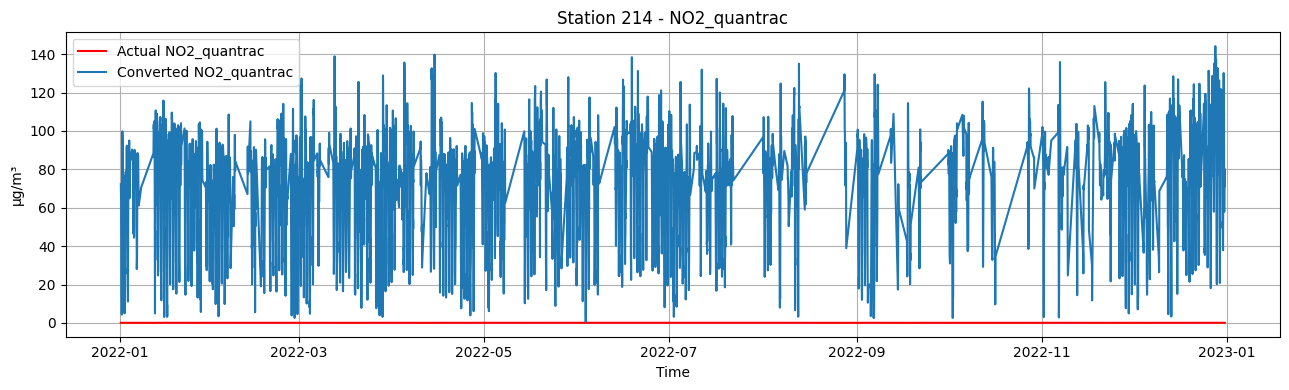

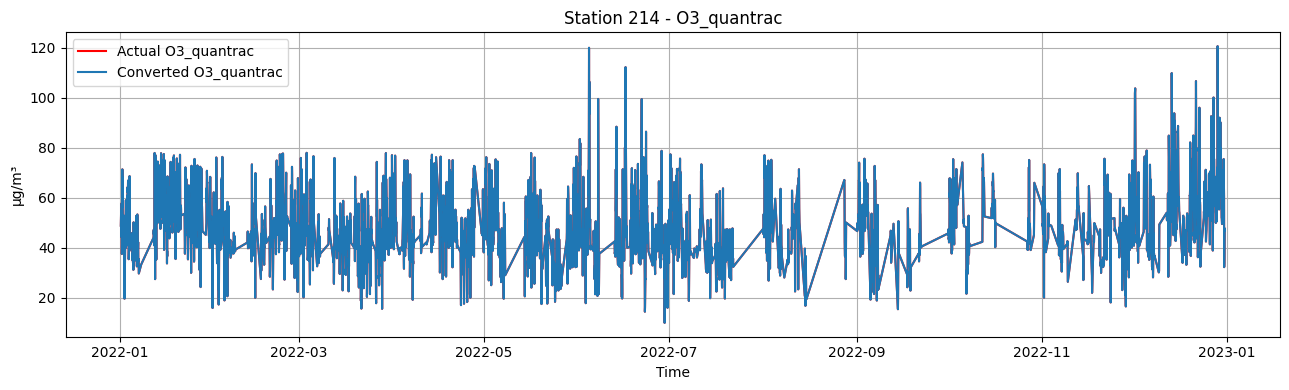

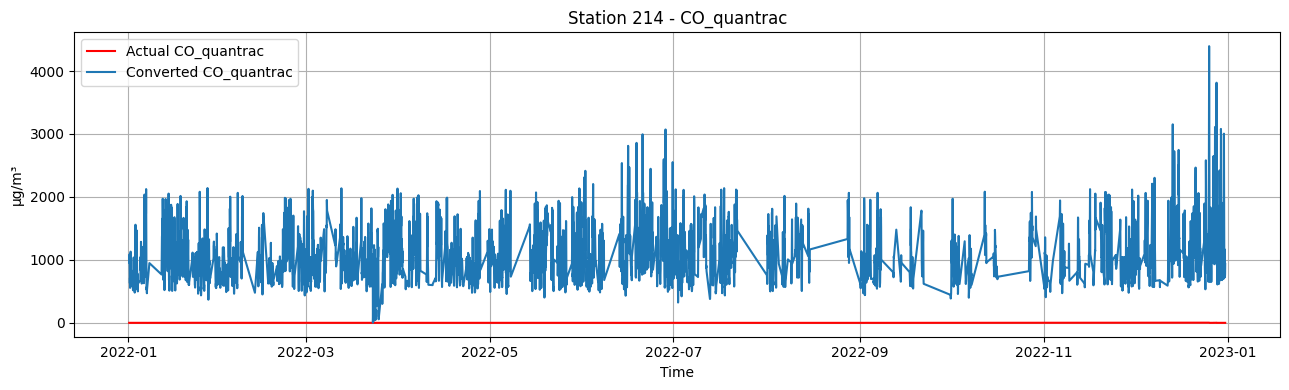

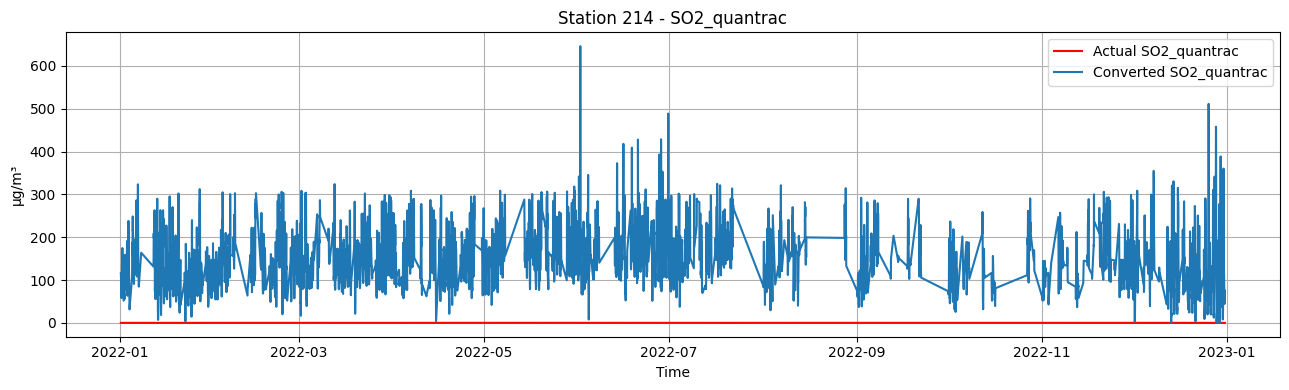

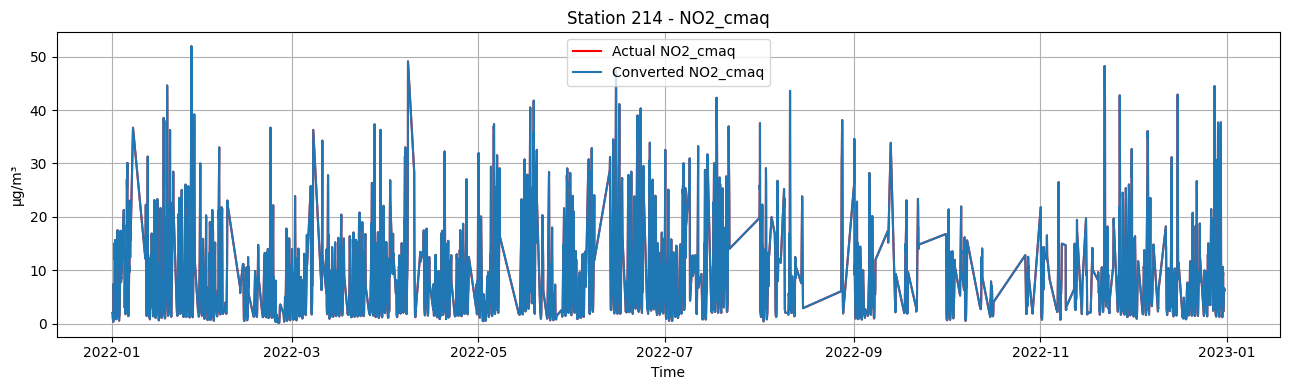

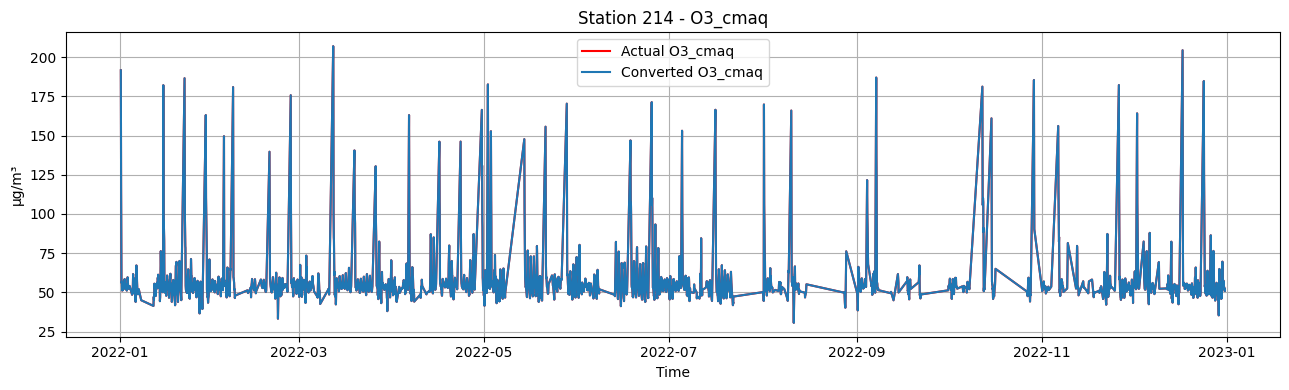

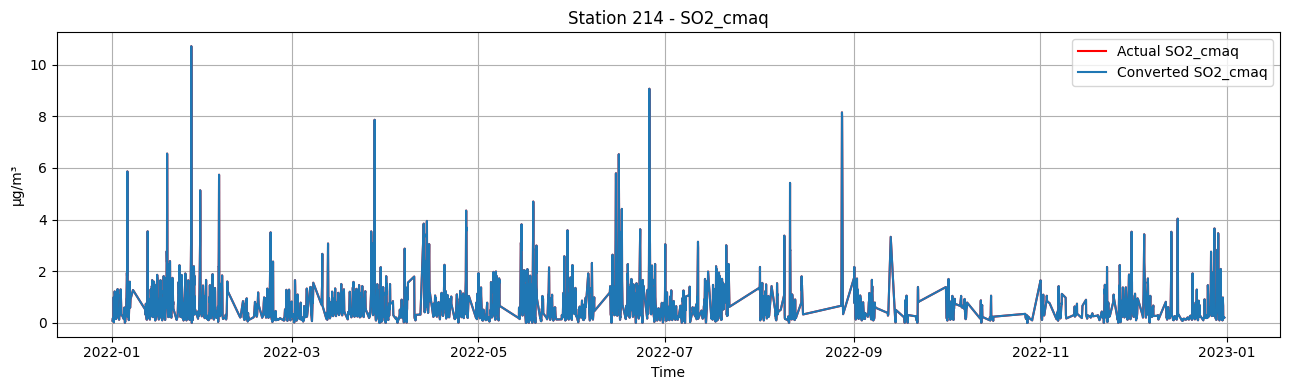

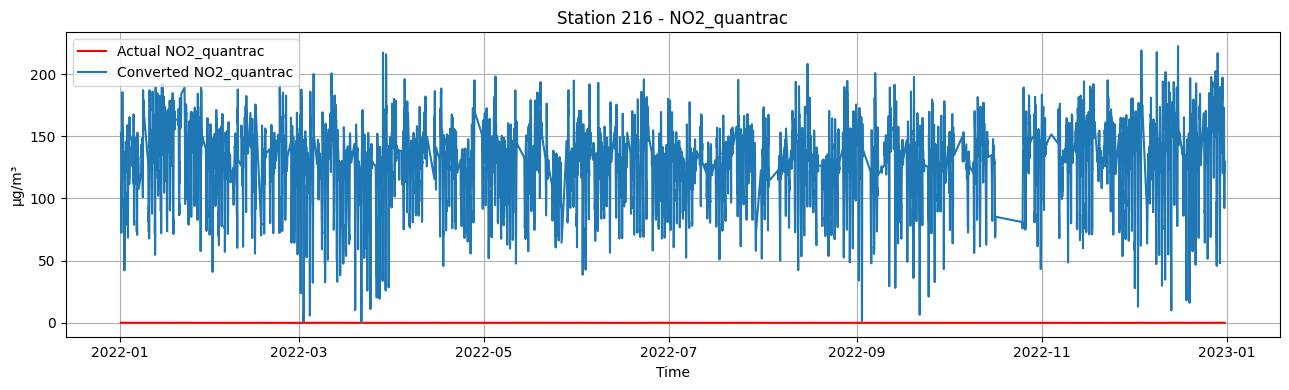

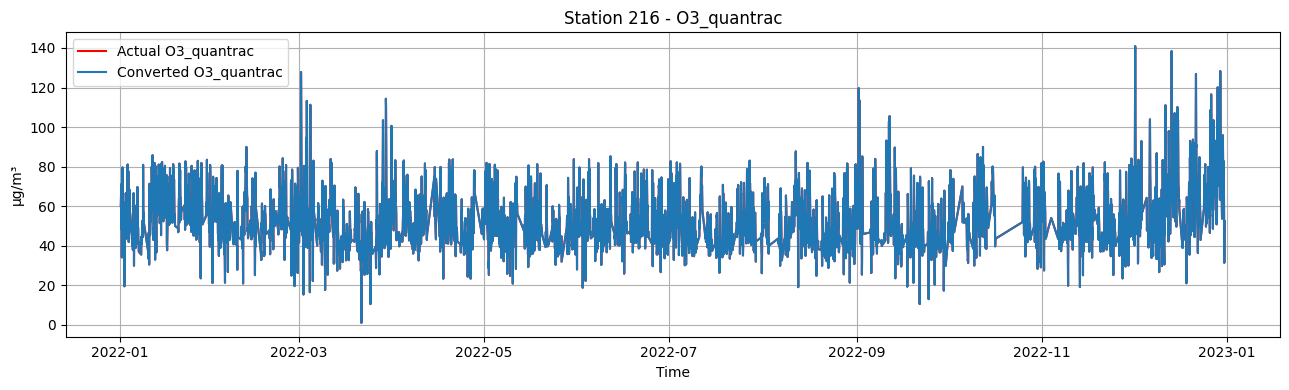

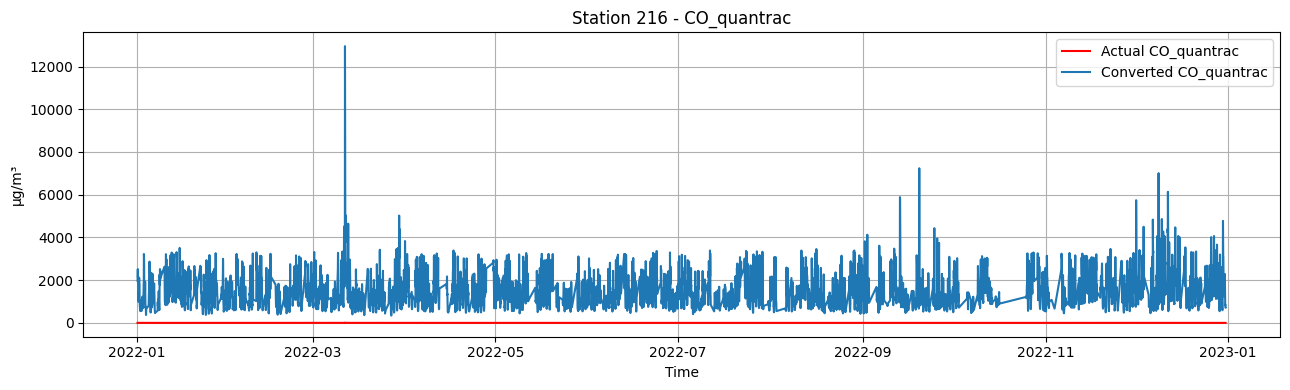

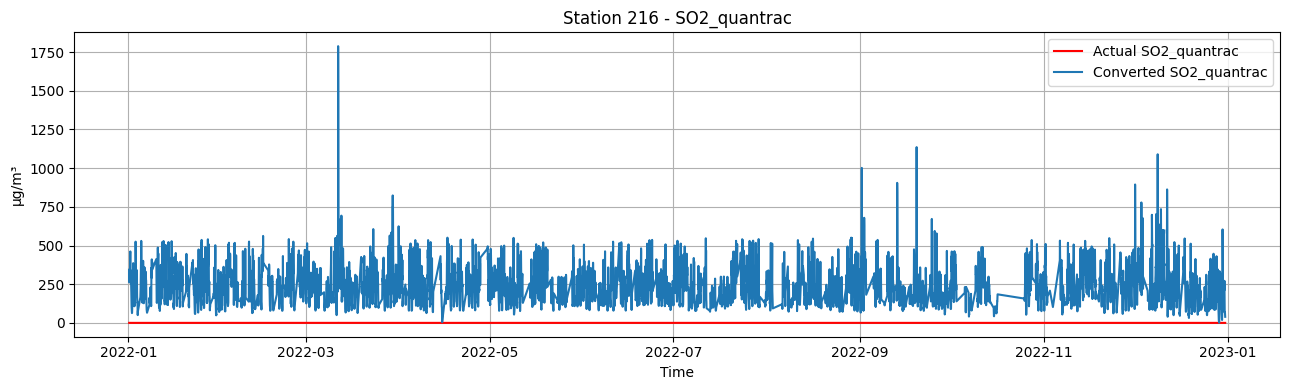

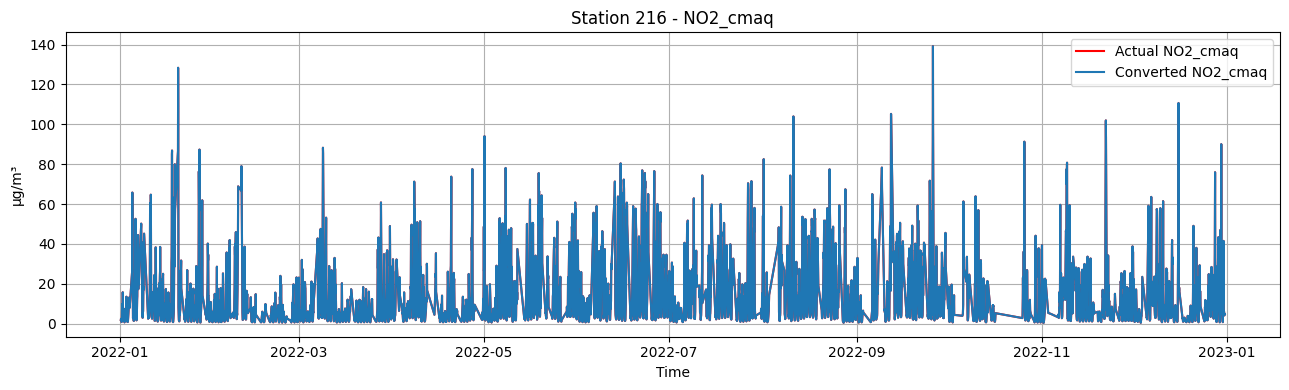

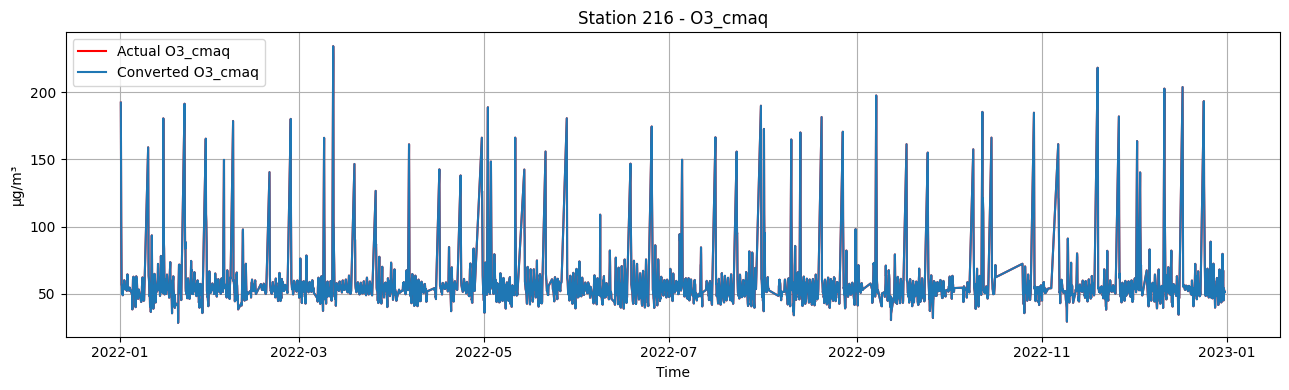

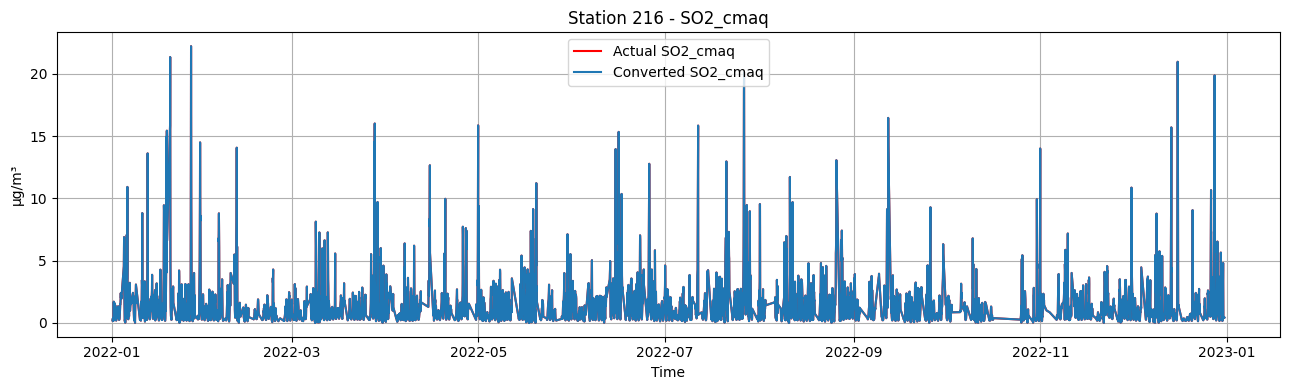

In [11]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [12]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# Since we only have 1 station, we don't need to query for each station

# 216 CO quantrac
#test = test.drop(index=test[test["CO_quantrac"] > 6000].index)
#test = test.drop(index=test[test["SO2_quantrac"] > 6000].index)
#test = test.drop(index=test[test["NO2_cmaq"] > 100].index)

# 216 SO2 quantrac
test216 = test[test["station_id"] == 216]
#test = test.drop(index=test216[test216["SO2_quantrac"] > 700].index, errors="ignore")
test = test.drop(index=test216[test216["SO2_quantrac"] > 500].index, errors="ignore")
test = test.drop(index=test216[test216["O3_quantrac"] > 120].index, errors="ignore")
test = test.drop(index=test216[test216["NO2_cmaq"] > 80].index, errors="ignore")
test = test.drop(index=test216[test216["O3_cmaq"] > 200].index, errors="ignore")
#test = test.drop(index=test216[test216["O3_cmaq"] > 100].index, errors="ignore")
test = test.drop(index=test216[test216["SO2_cmaq"] > 40000].index, errors="ignore")
#test = test.drop(index=test216[test216["SO2_cmaq"] > 1000].index, errors="ignore")

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 11521 records
After: 11323 records
Removed 198 records


## Visualization after removing outliers

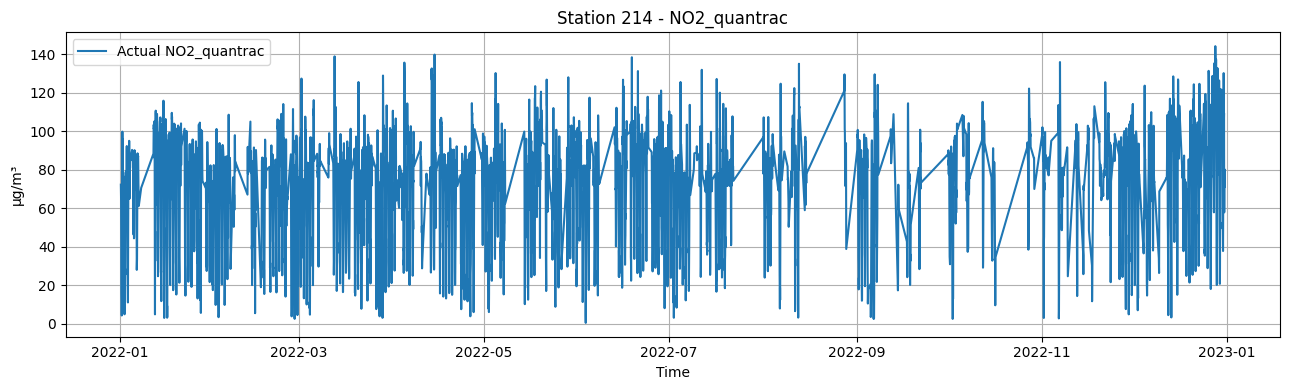

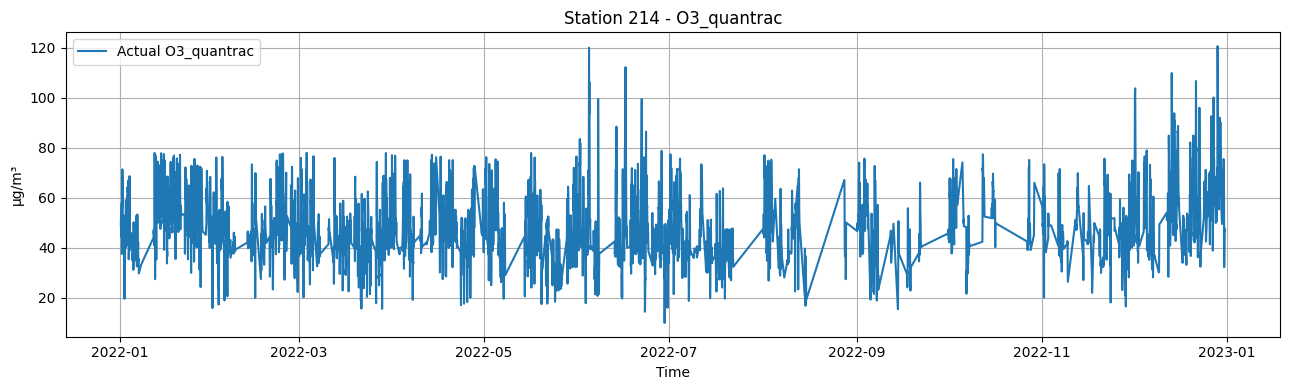

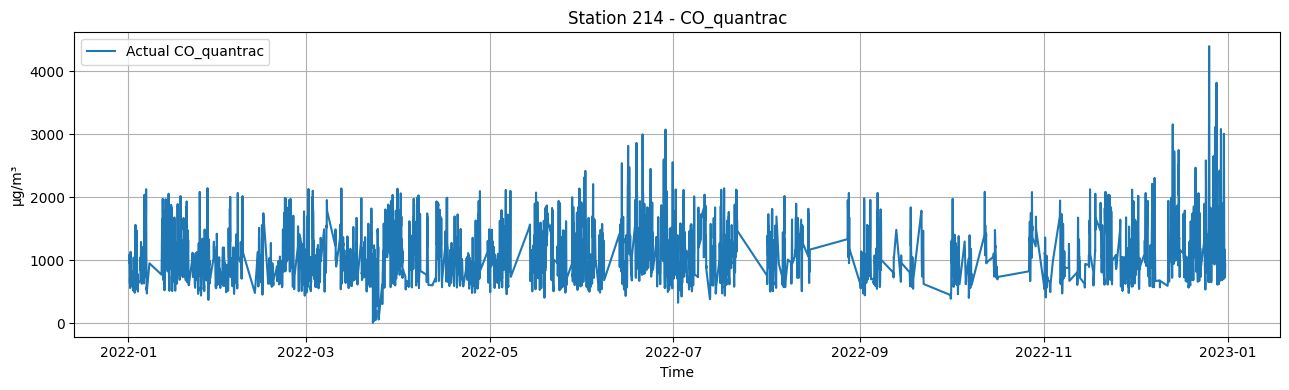

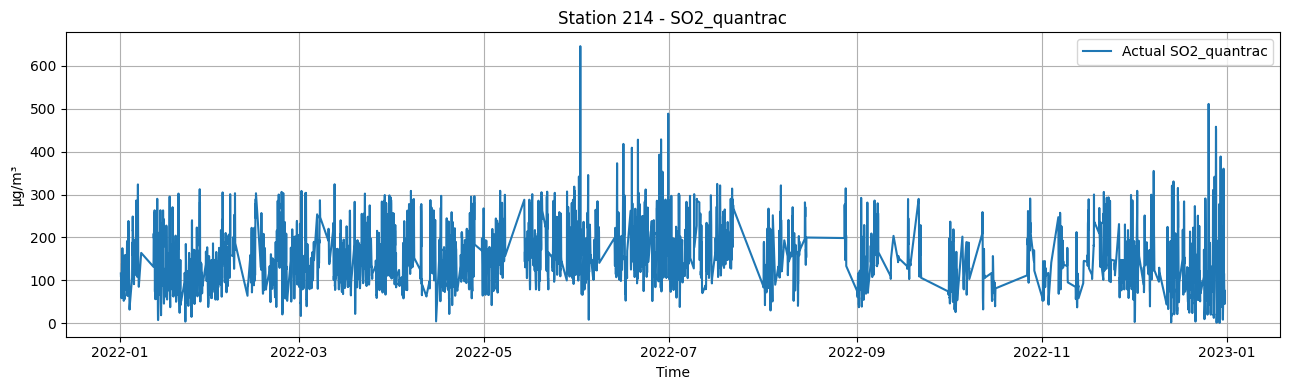

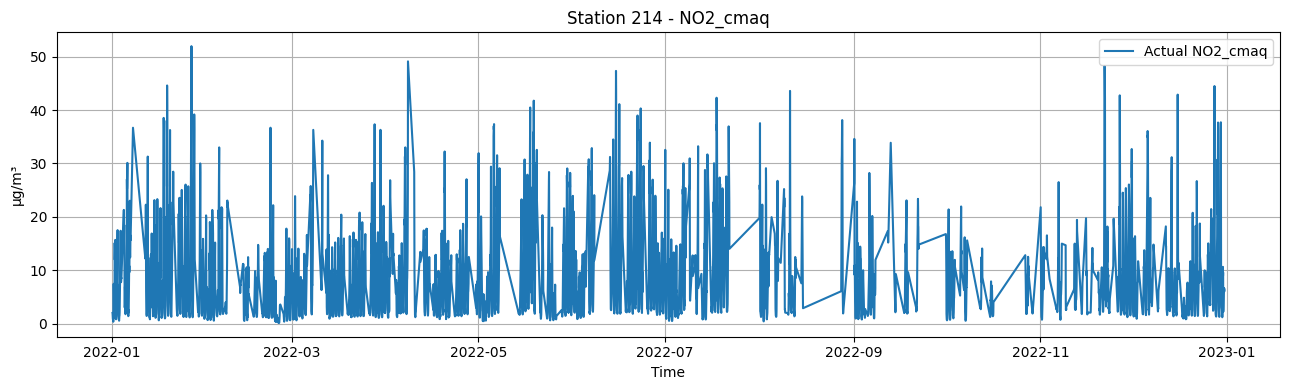

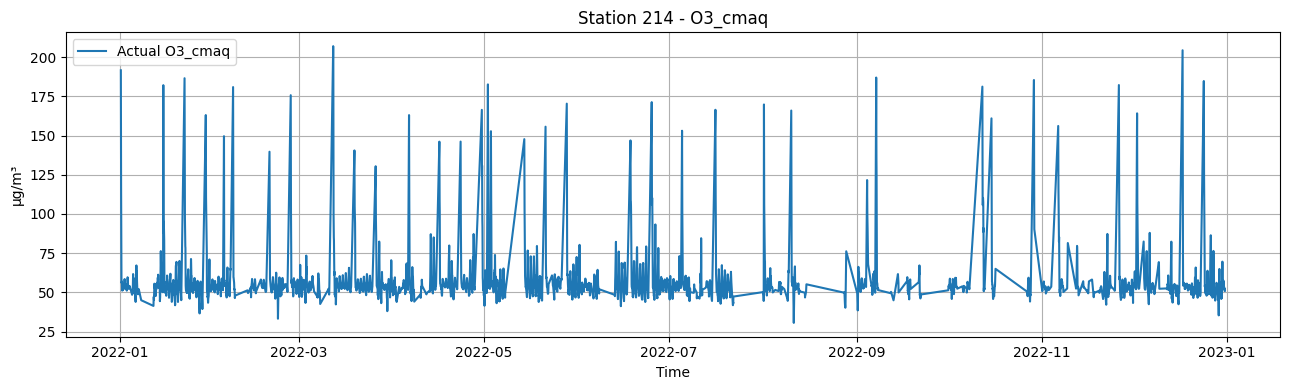

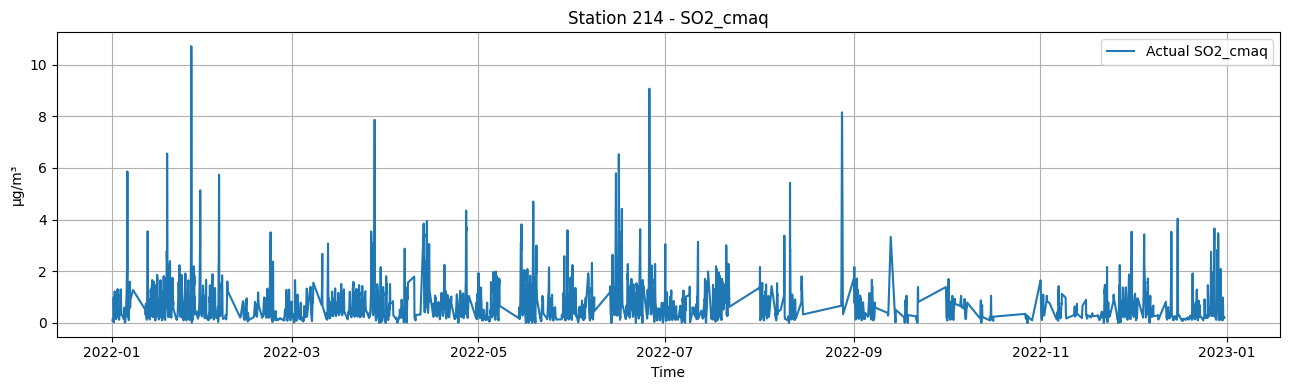

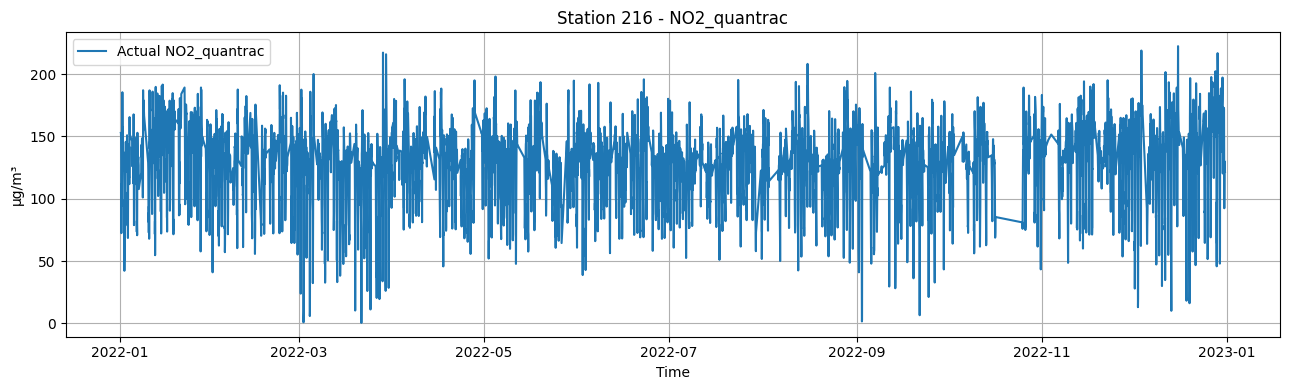

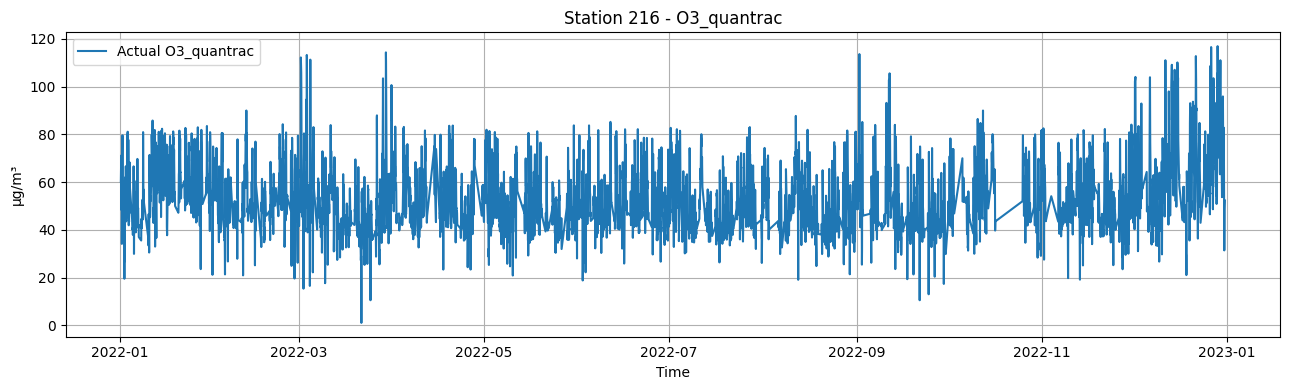

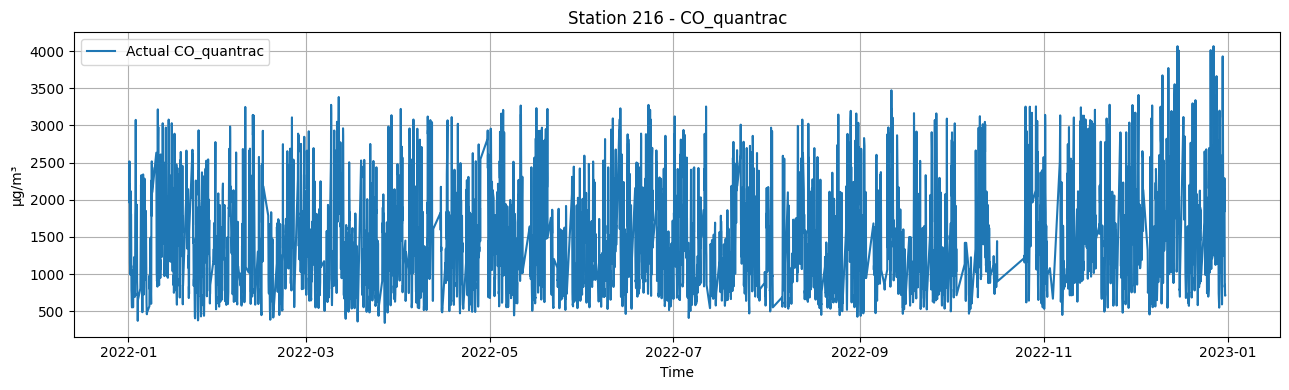

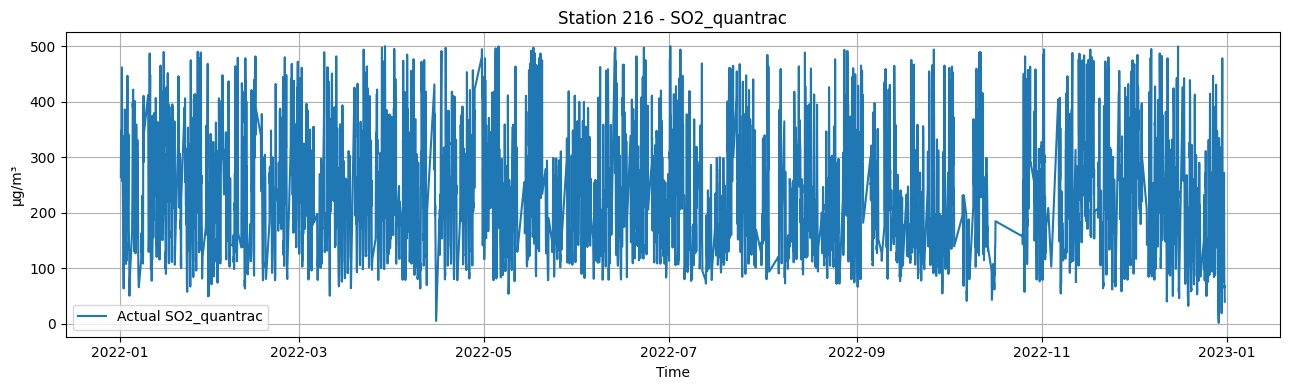

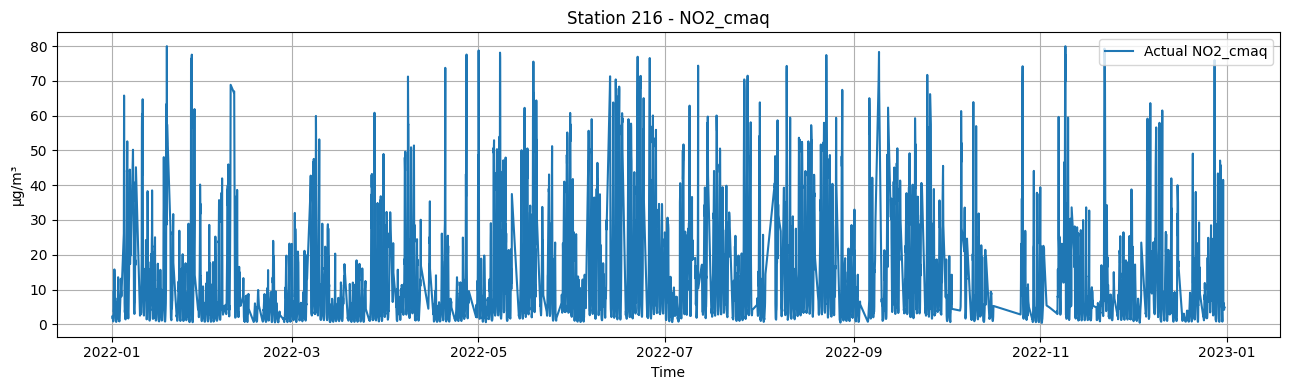

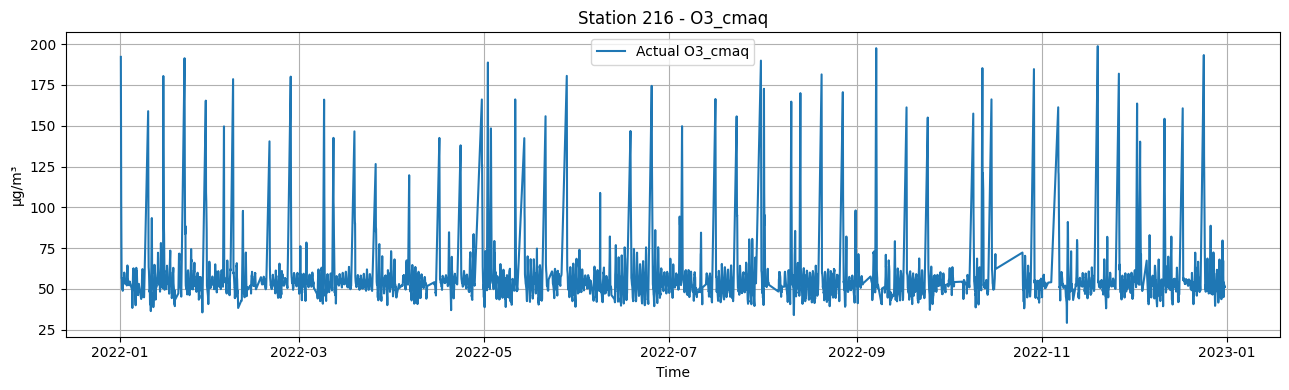

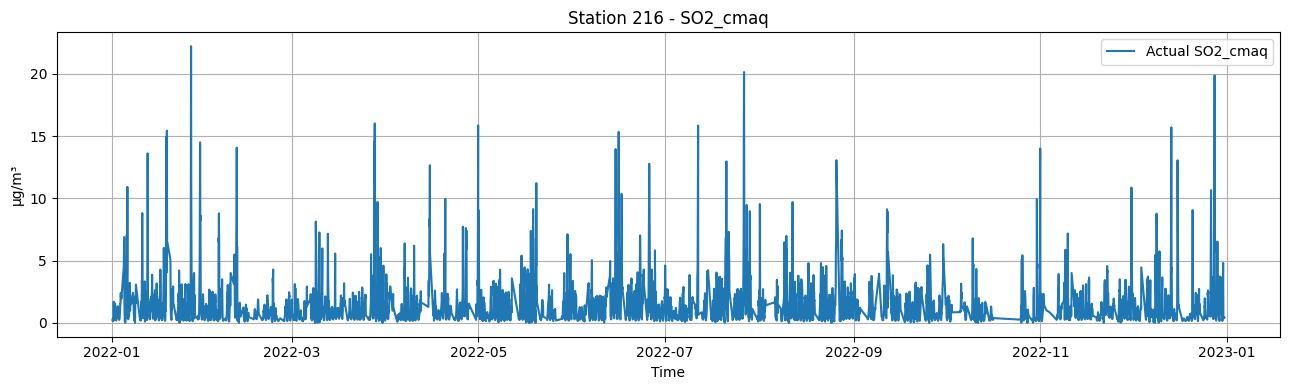

In [13]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Feature engineering

### Time features

In [14]:
# Add time features and lag feature for all gases
dftestso2 = add_time_features(df_converted)
dftestso2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)
dftestso2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["SO2_quantrac"], windows=ROLL_WINDOWS)
print(dftestso2.shape)
print(dftestso2.columns)
dftestso2

(11323, 22)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'SO2_quantrac', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq', 'station_id',
       'SO2_quantrac_roll3_mean', 'SO2_quantrac_roll3_std',
       'SO2_quantrac_roll6_mean', 'SO2_quantrac_roll6_std',
       'SO2_quantrac_roll12_mean', 'SO2_quantrac_roll12_std',
       'SO2_quantrac_roll24_mean', 'SO2_quantrac_roll24_std',
       'SO2_quantrac_roll48_mean', 'SO2_quantrac_roll48_std',
       'SO2_quantrac_roll72_mean', 'SO2_quantrac_roll72_std'],
      dtype='object')


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 07:00:00     72.283493      25.058333    48.800000   
1     2022-01-01 08:00:00     67.987363      26.491837    51.408163   
2     2022-01-01 09:00:00     63.686400      29.060000    54.545455   
3     2022-01-01 10:00:00     44.882933      28.475000    51.500000   
4     2022-01-01 11:00:00     29.126827      21.743333    44.300000   
...                   ...           ...            ...          ...   
11318 2022-12-31 01:00:00     92.346548      17.709259    31.425926   
11319 2022-12-31 02:00:00    119.184217      22.803390    43.220339   
11320 2022-12-31 03:00:00    130.034960      23.031667    48.866667   
11321 2022-12-31 04:00:00    121.654720      22.331667    50.633333   
11322 2022-12-31 05:00:00    121.497787      20.108333    52.333333   

       CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  \
0       957.578000    115.716667  2.014461  191.530965  0.087508         214   
1       970.801306    108.008163  1.793782  144.585143  0.129166         214   
2      1087.374909    112.898182  1.255505  116.822409  0.167680         214   
3      1006.508133     98.250000  0.910386   96.557955  0.184186         214   
4       764.342200     81.220000  0.788758   77.925827  0.148554         214   
...            ...           ...       ...         ...       ...         ...   
11318   945.048148     83.451852  4.285888   51.784937  0.389183         216   
11319   822.974780     64.833898  4.157322   51.295325  0.386550         216   
11320   855.703933     68.556667  4.235773   51.130547  0.394695         216   
11321   708.340133     53.273333  5.047855   51.640614  0.435544         216   
11322   712.736200     39.300000  4.876919   51.160312  0.429932         216   

       ...  SO2_quantrac_roll6_mean  SO2_quantrac_roll6_std  \
0      ...                      NaN                     NaN   
1      ...               115.716667                     NaN   
2      ...               111.862415                5.450735   
3      ...               112.207671                3.900367   
4      ...               108.718253                7.671118   
...    ...                      ...                     ...   
11318  ...               227.357778               34.000232   
11319  ...               201.893642               67.111291   
11320  ...               172.744292               83.397005   
11321  ...               144.943181               86.106688   
11322  ...               118.670403               86.002320   

       SO2_quantrac_roll12_mean  SO2_quantrac_roll12_std  \
0                           NaN                      NaN   
1                    115.716667                      NaN   
2                    111.862415                 5.450735   
3                    112.207671                 3.900367   
4                    108.718253                 7.671118   
...                         ...                      ...   
11318                183.581944                61.221300   
11319                180.129043                65.827843   
11320                179.272979                67.366589   
11321                174.287701                73.416991   
11322                169.229646                79.766617   

       SO2_quantrac_roll24_mean  SO2_quantrac_roll24_std  \
0                           NaN                      NaN   
1                    115.716667                      NaN   
2                    111.862415                 5.450735   
3                    112.207671                 3.900367   
4                    108.718253                 7.671118   
...                         ...                      ...   
11318                182.861259               111.943812   
11319                179.661059               113.702141   
11320                178.341499               114.886777   
11321                179.680795               113.337216   
11322                180.790656               111.894602   

       S

### Station embedding

In [15]:
test_station_to_embedding, _ = learn_station_embeddings(dftestso2, target_col="SO2_quantrac", station_col="station_id", embed_dim=4)
print(test_station_to_embedding)

dftestso2, _ = attach_station_embedding(dftestso2, test_station_to_embedding, station_col="station_id")
display(dftestso2)

[Embed] epoch 001 | train MSE=44218.2741 | val MSE=45464.7132
[Embed] epoch 010 | train MSE=43613.7082 | val MSE=44832.1748
[Embed] epoch 020 | train MSE=41918.0456 | val MSE=42983.4002
[Embed] epoch 030 | train MSE=38275.6809 | val MSE=39151.9378
[Embed] epoch 040 | train MSE=33010.9075 | val MSE=33725.4624
[Embed] epoch 050 | train MSE=26990.3189 | val MSE=27591.7589
{214: [-2.493279, -3.4780624, 3.4265149, -3.230457], 216: [-3.9687586, -3.8120093, 5.4187794, -4.117218]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 07:00:00     72.283493      25.058333    48.800000   
1     2022-01-01 08:00:00     67.987363      26.491837    51.408163   
2     2022-01-01 09:00:00     63.686400      29.060000    54.545455   
3     2022-01-01 10:00:00     44.882933      28.475000    51.500000   
4     2022-01-01 11:00:00     29.126827      21.743333    44.300000   
...                   ...           ...            ...          ...   
11318 2022-12-31 01:00:00     92.346548      17.709259    31.425926   
11319 2022-12-31 02:00:00    119.184217      22.803390    43.220339   
11320 2022-12-31 03:00:00    130.034960      23.031667    48.866667   
11321 2022-12-31 04:00:00    121.654720      22.331667    50.633333   
11322 2022-12-31 05:00:00    121.497787      20.108333    52.333333   

       CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  \
0       957.578000    115.716667  2.014461  191.530965  0.087508         214   
1       970.801306    108.008163  1.793782  144.585143  0.129166         214   
2      1087.374909    112.898182  1.255505  116.822409  0.167680         214   
3      1006.508133     98.250000  0.910386   96.557955  0.184186         214   
4       764.342200     81.220000  0.788758   77.925827  0.148554         214   
...            ...           ...       ...         ...       ...         ...   
11318   945.048148     83.451852  4.285888   51.784937  0.389183         216   
11319   822.974780     64.833898  4.157322   51.295325  0.386550         216   
11320   855.703933     68.556667  4.235773   51.130547  0.394695         216   
11321   708.340133     53.273333  5.047855   51.640614  0.435544         216   
11322   712.736200     39.300000  4.876919   51.160312  0.429932         216   

       ...  SO2_quantrac_roll24_mean  SO2_quantrac_roll24_std  \
0      ...                       NaN                      NaN   
1      ...                115.716667                      NaN   
2      ...                111.862415                 5.450735   
3      ...                112.207671                 3.900367   
4      ...                108.718253                 7.671118   
...    ...                       ...                      ...   
11318  ...                182.861259               111.943812   
11319  ...                179.661059               113.702141   
11320  ...                178.341499               114.886777   
11321  ...                179.680795               113.337216   
11322  ...                180.790656               111.894602   

       SO2_quantrac_roll48_mean  SO2_quantrac_roll48_std  \
0                           NaN                      NaN   
1                    115.716667                      NaN   
2                    111.862415                 5.450735   
3                    112.207671                 3.900367   
4                    108.718253                 7.671118   
...                         ...                      ...   
11318                177.836046               108.240992   
11319                173.042821               107.193493   
11320                168.753250               107.320699   
11321                167.643388               108.088996   
11322                166.724569               108.883544   

       SO2_quantrac_roll72_mean  SO2_quantrac_roll72_std  station_emb_0  \
0                           NaN                      NaN      -2.493279   
1                    115.716667                      NaN      -2.493279   
2                    111.862415                 5.450735      -2.493279   
3                    112.207671                 3.900367      -2.493279   
4                    108.718253                 7.671118      -2.493279   
...                         ...                      ...            ...   
11318                200.958427               106.799173      -3.968759   
11319                198.308777               107.321065      -3.968759   
11320                195.74623

## Build supervised from time-series

In [16]:
# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestso2, horizon_h=72, target_col="SO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (11177, 25) (11177, 3)
Index(['date', 'station_id', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac',
       'CO_quantrac', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq',
       'SO2_quantrac_roll3_mean', 'SO2_quantrac_roll3_std',
       'SO2_quantrac_roll6_mean', 'SO2_quantrac_roll6_std',
       'SO2_quantrac_roll12_mean', 'SO2_quantrac_roll12_std',
       'SO2_quantrac_roll24_mean', 'SO2_quantrac_roll24_std',
       'SO2_quantrac_roll48_mean', 'SO2_quantrac_roll48_std',
       'SO2_quantrac_roll72_mean', 'SO2_quantrac_roll72_std', 'station_emb_0',
       'station_emb_1', 'station_emb_2', 'station_emb_3'],
      dtype='object')
Index(['date', 'station_id', 'SO2_quantrac_t_plus_72h'], dtype='object')


date  station_id  NO2_quantrac  PM25_quantrac  \
0     2022-01-01 09:00:00         214     63.686400      29.060000   
1     2022-01-01 10:00:00         214     44.882933      28.475000   
2     2022-01-01 11:00:00         214     29.126827      21.743333   
3     2022-01-01 12:00:00         214     15.693333      21.645000   
4     2022-01-01 13:00:00         214     11.959972      28.726316   
...                   ...         ...           ...            ...   
11172 2022-12-27 19:00:00         216    159.130400      35.258333   
11173 2022-12-27 20:00:00         216    165.752987      41.721667   
11174 2022-12-27 21:00:00         216    178.527360      50.540000   
11175 2022-12-27 22:00:00         216    180.787200      53.945000   
11176 2022-12-27 23:00:00         216    165.031093      33.321667   

       O3_quantrac  CO_quantrac   NO2_cmaq     O3_cmaq   SO2_cmaq  \
0        54.545455  1087.374909   1.255505  116.822409   0.167680   
1        51.500000  1006.508133   0.910386   96.557955   0.184186   
2        44.300000   764.342200   0.788758   77.925827   0.148554   
3        45.783333   629.784333   0.557162   56.285232   0.106634   
4        57.719298   715.643439   0.371098   56.048611   0.086984   
...            ...          ...        ...         ...        ...   
11172    76.116667  2450.138200  20.748646   48.384501   7.332667   
11173    78.383333  2186.183067  21.971180   48.457658   6.862372   
11174    70.883333  3397.203867  22.201322   48.504896   5.678386   
11175    68.000000  3267.424333  34.812875   46.893053  10.498039   
11176    74.233333  1633.998867  59.889300   43.220554  19.342058   

       SO2_quantrac_roll3_mean  ...  SO2_quantrac_roll24_mean  \
0                   111.862415  ...                111.862415   
1                   112.207671  ...                112.207671   
2                   106.385448  ...                108.718253   
3                    97.456061  ...                103.218602   
4                    79.182222  ...                 95.694946   
...                        ...  ...                       ...   
11172               229.250000  ...                200.711467   
11173               262.436667  ...                204.277578   
11174               253.848889  ...                207.443411   
11175               304.793333  ...                219.579106   
11176               335.796667  ...                230.604939   

       SO2_quantrac_roll24_std  SO2_quantrac_roll48_mean  \
0                     5.450735                111.862415   
1                     3.900367                112.207671   
2                     7.671118                108.718253   
3                    13.977314                103.218602   
4                    22.269366                 95.694946   
...                        ...                       ...   
11172                90.406453                202.404400   
11173                91.589839                203.350511   
11174                91.787502                202.377109   
11175                96.058421                203.623428   
11176                97.229212                205.934123   

       SO2_quantrac_roll48_std  SO2_quantrac_roll72_mean  \
0                     5.450735                111.862415   
1                     3.900367                112.207671   
2                     7.671118                108.718253   
3                    13.977314                103.218602   
4                    22.269366                 95.694946   
...                        ...                       ...   
11172                90.379304                180.271032   
11173                90.897851                180.501495   
11174                90.130863                180.198254   
11175                92.333886                182.211772   
11176                95.029268                182.994134   

       SO2_quantrac_roll72_std  station_emb_0  station_emb_1  station_emb_2  \
0                     5.450735      -2.493279    

date  station_id  SO2_quantrac_t_plus_72h
0     2022-01-01 09:00:00         214               158.946667
1     2022-01-01 10:00:00         214               197.373333
2     2022-01-01 11:00:00         214               248.661818
3     2022-01-01 12:00:00         214               214.840000
4     2022-01-01 13:00:00         214               217.460000
...                   ...         ...                      ...
11172 2022-12-27 19:00:00         216                83.451852
11173 2022-12-27 20:00:00         216                64.833898
11174 2022-12-27 21:00:00         216                68.556667
11175 2022-12-27 22:00:00         216                53.273333
11176 2022-12-27 23:00:00         216                39.300000

[11177 rows x 3 columns]

## Split train/validation/test for each station

In [17]:
# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

NO2_quantrac  PM25_quantrac  O3_quantrac  CO_quantrac   NO2_cmaq  \
4051      49.559547      13.361667    33.916667   708.722400   0.737101   
4052      62.553627      15.210000    41.583333   714.074133   1.073496   
4053      75.994967      15.835417    49.125000   781.735333   1.839741   
4054      67.544107      15.750000    41.983333   991.790867   2.979759   
4055      65.943387      14.243333    40.950000   948.977000   5.476967   
...             ...            ...          ...          ...        ...   
11172    159.130400      35.258333    76.116667  2450.138200  20.748646   
11173    165.752987      41.721667    78.383333  2186.183067  21.971180   
11174    178.527360      50.540000    70.883333  3397.203867  22.201322   
11175    180.787200      53.945000    68.000000  3267.424333  34.812875   
11176    165.031093      33.321667    74.233333  1633.998867  59.889300   

         O3_cmaq   SO2_cmaq  SO2_quantrac_roll3_mean  SO2_quantrac_roll3_std  \
4051   56.266657   0.174492               160.438611               37.052449   
4052   56.918980   0.188902               135.985278                6.388194   
4053   56.201851   0.225582               131.000000                4.300668   
4054   54.953426   0.262469               128.671111                1.098920   
4055   53.549615   0.424786               142.790000               25.345482   
...          ...        ...                      ...                     ...   
11172  48.384501   7.332667               229.250000               50.783038   
11173  48.457658   6.862372               262.436667               21.181709   
11174  48.504896   5.678386               253.848889               18.538201   
11175  46.893053  10.498039               304.793333               75.530712   
11176  43.220554  19.342058               335.796667               75.799095   

       SO2_quantrac_roll6_mean  ...  SO2_quantrac_roll24_mean  \
4051                168.411120  ...                159.558307   
4052                167.479861  ...                159.030668   
4053                160.711528  ...                158.139140   
4054                144.554861  ...                155.992196   
4055                139.387639  ...                156.427029   
...                        ...  ...                       ...   
11172               162.876667  ...                200.711467   
11173               190.095556  ...                204.277578   
11174               215.858889  ...                207.443411   
11175               267.021667  ...                219.579106   
11176               299.116667  ...                230.604939   

       SO2_quantrac_roll24_std  SO2_quantrac_roll48_mean  \
4051                 50.615833                136.826035   
4052                 50.868356                136.798744   
4053                 51.239712                136.744160   
4054                 51.348275                136.411393   
4055                 51.442024                137.575838   
...                        ...                       ...   
11172                90.406453                202.404400   
11173                91.589839                203.350511   
11174                91.787502                202.377109   
11175                96.058421                203.623428   
11176                97.229212                205.934123   

       SO2_quantrac_roll48_std  SO2_quantrac_roll72_mean  \
4051                 56.461187                128.452172   
4052                 56.464380                127.008747   
4053                 56.472232                125.881794   
4054                 56.470877                125.669525   
4055                 56.620332                125.699849   
...                        ...                       ...   
11172                90.379304                180.271032   
11173                90.897851                180.501495   
11174                90.130863                180.198254   
11175                92.333886             

# LightGBM model

## Define model

## Add time and lags features

In [18]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for SO2

In [19]:
label = "SO2_quantrac"

# Add rolling features for LABEL
df_so2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)

# Station embedding
so2_station_to_embedding, _ = learn_station_embeddings(df_so2, target_col=label, station_col="station_id", embed_dim=4)
df_so2, _ = attach_station_embedding(df_so2, so2_station_to_embedding, station_col="station_id")
print(so2_station_to_embedding)
with open(os.path.join(LIGHTGBM_DIR, f"{label}_pmcmaq_station_embedding.pkl"), 'wb') as so2_emb_file:
    pickle.dump(so2_station_to_embedding, so2_emb_file)

# Print dataset
display(df_so2)

# Start running model
so2_all_metrics = []
so2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_so2, horizon_h=h, target_col=label, calibrate=True, learning_rate=0.01)
    so2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_pmcmaq_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    so2_all_metrics.append(metrics_by_station)

# Metrics table
so2_df_metrics_all = pd.concat(so2_all_metrics, ignore_index=True)
so2_df_metrics_all = so2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
so2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"), index=False)
so2_df_metrics_all

[Embed] epoch 001 | train MSE=44218.2741 | val MSE=45464.7132
[Embed] epoch 010 | train MSE=43613.7082 | val MSE=44832.1748
[Embed] epoch 020 | train MSE=41918.0456 | val MSE=42983.4002
[Embed] epoch 030 | train MSE=38275.6809 | val MSE=39151.9378
[Embed] epoch 040 | train MSE=33010.9075 | val MSE=33725.4624
[Embed] epoch 050 | train MSE=26990.3189 | val MSE=27591.7589
{214: [-2.493279, -3.4780624, 3.4265149, -3.230457], 216: [-3.9687586, -3.8120093, 5.4187794, -4.117218]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 07:00:00     72.283493      25.058333    48.800000   
1     2022-01-01 08:00:00     67.987363      26.491837    51.408163   
2     2022-01-01 09:00:00     63.686400      29.060000    54.545455   
3     2022-01-01 10:00:00     44.882933      28.475000    51.500000   
4     2022-01-01 11:00:00     29.126827      21.743333    44.300000   
...                   ...           ...            ...          ...   
11318 2022-12-31 01:00:00     92.346548      17.709259    31.425926   
11319 2022-12-31 02:00:00    119.184217      22.803390    43.220339   
11320 2022-12-31 03:00:00    130.034960      23.031667    48.866667   
11321 2022-12-31 04:00:00    121.654720      22.331667    50.633333   
11322 2022-12-31 05:00:00    121.497787      20.108333    52.333333   

       CO_quantrac  SO2_quantrac  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id  \
0       957.578000    115.716667  2.014461  191.530965  0.087508         214   
1       970.801306    108.008163  1.793782  144.585143  0.129166         214   
2      1087.374909    112.898182  1.255505  116.822409  0.167680         214   
3      1006.508133     98.250000  0.910386   96.557955  0.184186         214   
4       764.342200     81.220000  0.788758   77.925827  0.148554         214   
...            ...           ...       ...         ...       ...         ...   
11318   945.048148     83.451852  4.285888   51.784937  0.389183         216   
11319   822.974780     64.833898  4.157322   51.295325  0.386550         216   
11320   855.703933     68.556667  4.235773   51.130547  0.394695         216   
11321   708.340133     53.273333  5.047855   51.640614  0.435544         216   
11322   712.736200     39.300000  4.876919   51.160312  0.429932         216   

       ...  SO2_quantrac_roll24_mean  SO2_quantrac_roll24_std  \
0      ...                       NaN                      NaN   
1      ...                115.716667                      NaN   
2      ...                111.862415                 5.450735   
3      ...                112.207671                 3.900367   
4      ...                108.718253                 7.671118   
...    ...                       ...                      ...   
11318  ...                182.861259               111.943812   
11319  ...                179.661059               113.702141   
11320  ...                178.341499               114.886777   
11321  ...                179.680795               113.337216   
11322  ...                180.790656               111.894602   

       SO2_quantrac_roll48_mean  SO2_quantrac_roll48_std  \
0                           NaN                      NaN   
1                    115.716667                      NaN   
2                    111.862415                 5.450735   
3                    112.207671                 3.900367   
4                    108.718253                 7.671118   
...                         ...                      ...   
11318                177.836046               108.240992   
11319                173.042821               107.193493   
11320                168.753250               107.320699   
11321                167.643388               108.088996   
11322                166.724569               108.883544   

       SO2_quantrac_roll72_mean  SO2_quantrac_roll72_std  station_emb_0  \
0                           NaN                      NaN      -2.493279   
1                    115.716667                      NaN      -2.493279   
2                    111.862415                 5.450735      -2.493279   
3                    112.207671                 3.900367      -2.493279   
4                    108.718253                 7.671118      -2.493279   
...                         ...                      ...            ...   
11318                200.958427               106.799173      -3.968759   
11319                198.308777               107.321065      -3.968759   
11320                195.74623


===== Training LightGBM for horizon = 1h, target_col = SO2_quantrac =====

X.shape = (11177, 76)
y.shape = (11177, 3)

Number of features: 76

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
NO2_quantrac_lag48
NO2_quantrac_lag72
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
PM25_quantrac_lag48
PM25_quantrac_lag72
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
O3_quantrac_lag48
O3_quantrac_lag72
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
CO_quantrac_lag48
CO_quantrac_lag72
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_lag48
SO2_quantrac_lag72
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO2_cmaq_lag48
NO2_cmaq_lag72
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
O3_cmaq_lag48
O3_cmaq_lag72
SO2_cmaq

array([[227.65420116],
       [221.81503832],
       [199.30111919],
       ...,
       [127.84763148],
       [128.16963737],
       [118.11089198]])

[hiepdebug]  y_pred_corr...


array([[210.42702053],
       [204.12414367],
       [179.8222936 ],
       ...,
       [102.69436508],
       [103.0419429 ],
       [ 92.18438758]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([227.65420116, 221.81503832, 199.30111919, 178.7721399 ,
       140.49832206, 142.70911778, 141.9999281 , 147.1261122 ,
       159.23123972, 162.59782844, 213.77350438, 210.69384127,
       211.59457286, 166.29468783, 147.18488929, 144.95234442,
       158.42309638, 117.52341578, 103.97997187, 123.7203764 ,
       242.5528755 , 249.30065756, 243.56390774, 259.62658898,
       226.7149101 , 212.36482848, 193.85115382, 173.84437302,
       192.75682266, 200.55113171, 232.85289003, 219.85753773,
       224.81024916, 201.2788963 , 210.99745048, 202.90684647,
       211.06566007, 205.81488172, 194.69936007, 214.30222452,
       174.59477   , 137.85960334, 121.85014647, 115.09859348,
       210.21407361, 245.49477546, 253.11736217, 168.1072084 ,
       179.1398335 , 196.65638785, 210.29056   , 185.56230535,
       154.64415192, 229.73053485, 204.69573548, 216.61442584,
       214.06226688, 189.36460084, 180.83185773, 184.35856555,
       241.14234812, 206.95770906, 156.70571185, 151.46

[hiepdebug]  y_pred_corr...


array([228.64523202, 221.43082489, 193.61440955, 168.25042867,
       120.9623307 , 123.69381479, 122.81759619, 129.15110327,
       144.10724009, 148.26673046, 211.49534246, 207.69035463,
       208.80322725, 152.83427713, 129.22372358, 126.46536796,
       143.10876218,  92.57635615,  75.84314952, 100.23282988,
       247.05285404, 255.38987912, 248.30200539, 268.14778215,
       227.48471838, 209.75489409, 186.88086399, 162.1620702 ,
       185.52879509, 195.15882602, 235.06832025, 219.0122922 ,
       225.13147017, 196.0579943 , 208.06547013, 198.06936061,
       208.1497445 , 201.66229863, 187.92884046, 212.14858719,
       163.08920128, 117.70213884,  97.92212191,  89.58043776,
       207.09759172, 250.68763263, 260.10549704, 155.073684  ,
       168.70472177, 190.34678898, 207.19209223, 176.63981931,
       138.43979771, 231.21058548, 200.27957018, 215.00536   ,
       211.85211453, 181.33763447, 170.79525289, 175.15257375,
       245.31011813, 203.07428558, 140.98689787, 134.50

sid = 214, grp =                     date  station_id      y_true      y_pred
4052 2022-11-19 21:00:00         214  213.093333  227.654201
4053 2022-11-19 22:00:00         214  199.556667  221.815038
4054 2022-11-19 23:00:00         214  196.500000  199.301119
4055 2022-11-20 00:00:00         214  147.206555  178.772140
4056 2022-11-20 01:00:00         214  147.206555  140.498322
...                  ...         ...         ...         ...
4763 2022-12-31 00:00:00         214   72.923333  105.622753
4764 2022-12-31 01:00:00         214   76.728571   92.565894
4765 2022-12-31 02:00:00         214   51.963333  100.111497
4766 2022-12-31 03:00:00         214   44.540000   87.303873
4767 2022-12-31 04:00:00         214   74.670000   99.467649

[716 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 19), datetime.date(2022, 11, 20), datetime.date(2022, 11, 21), datetime.date(2022, 11, 22), datetime.date(2022, 11, 23), datetime.date(2022, 11, 24), datetime.date(2022, 11, 25), datetime.da

date      target
0   2022-11-20  159.857155
1   2022-11-21  195.820442
2   2022-11-22  197.489861
3   2022-11-23  141.902652
4   2022-11-26  131.737835
5   2022-11-27  117.033831
6   2022-11-28  135.423575
7   2022-11-29  130.103747
8   2022-11-30  154.533602
9   2022-12-01   95.626347
10  2022-12-02  151.160402
11  2022-12-04  151.904682
12  2022-12-06  150.307900
13  2022-12-07  166.009742
14  2022-12-12   94.516636
15  2022-12-13  110.461093
16  2022-12-14  134.850578
17  2022-12-15  138.268681
18  2022-12-17  157.244130
19  2022-12-18   92.962689
20  2022-12-19   83.335549
21  2022-12-20  105.314717
22  2022-12-21  109.232604
23  2022-12-22  118.848396
24  2022-12-24  116.472577
25  2022-12-25  130.106352
26  2022-12-26   88.126303
27  2022-12-27  143.580159
28  2022-12-28  127.205374
29  2022-12-29  104.974147
30  2022-12-30  103.028162

date      target
0   2022-11-20  166.132259
1   2022-11-21  202.028854
2   2022-11-22  191.308156
3   2022-11-23  158.363254
4   2022-11-26  153.258510
5   2022-11-27  125.073413
6   2022-11-28  143.044747
7   2022-11-29  141.492141
8   2022-11-30  146.152100
9   2022-12-01  129.371696
10  2022-12-02  141.761812
11  2022-12-04  152.697674
12  2022-12-06  156.642126
13  2022-12-07  165.284302
14  2022-12-12  132.969481
15  2022-12-13  148.380839
16  2022-12-14  151.187543
17  2022-12-15  154.182735
18  2022-12-17  148.602675
19  2022-12-18  113.991941
20  2022-12-19  121.933868
21  2022-12-20  133.929655
22  2022-12-21  144.627370
23  2022-12-22  137.259622
24  2022-12-24  139.940414
25  2022-12-25  135.219525
26  2022-12-26  135.576307
27  2022-12-27  172.423468
28  2022-12-28  175.197026
29  2022-12-29  128.678637
30  2022-12-30  123.854597

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([150.23763131, 172.13946001, 240.77620937, 200.60653918,
       148.12068583,  99.92163931, 146.63762888, 192.01128668,
       326.19716133, 332.61030363, 318.22895764, 276.29703326,
       202.88105718, 184.5779977 , 160.48762551, 158.4430161 ,
       229.70795494, 267.11578136, 279.54682882, 215.82727999,
       261.96904105, 263.93026209, 246.04421304, 204.15472413,
       202.35362645, 210.5291337 , 132.72302562, 286.29720622,
       288.73472149, 305.08178288, 323.12094069, 329.26743804,
       368.5098963 , 370.15186561, 336.33772834, 309.29280985,
       270.85880069, 275.12139965, 189.52625301, 226.44849169,
       252.94069144, 289.95346673, 332.30670579, 342.35657158,
       348.49765386, 329.18650063, 231.20502397, 210.56128539,
       182.16977872, 166.03664316, 137.91758176, 164.53052766,
       179.56056627, 184.70137179, 219.96858251, 347.68324613,
       360.44045455, 334.7957778 , 345.00300876, 300.09855708,
       293.89104983, 334.25738843, 267.57070749, 268.05

[hiepdebug]  y_pred_corr...


array([120.01746076, 144.31762883, 220.47038156, 175.90196901,
       117.66870113,  64.19166288, 116.02324341, 166.36550139,
       315.24527537, 322.36068284, 306.40452095, 259.88088021,
       178.42555599, 158.11823701, 131.38987103, 129.12136858,
       208.19010822, 249.69424387, 263.48654161, 192.78944288,
       243.98391455, 246.15989727, 226.31525307, 179.83869466,
       177.84036945, 186.91112801, 100.58493447, 270.9761128 ,
       273.68054592, 291.81767706, 311.83219606, 318.65175987,
       362.19142701, 364.01319864, 326.49627574, 296.48982861,
       253.84713905, 258.57650994, 163.60834641, 204.57372049,
       233.96692391, 275.03274872, 322.02383981, 333.1742068 ,
       339.98776258, 318.56195949, 209.85111241, 186.94680045,
       155.44630825, 137.5465287 , 106.34831565, 135.87548742,
       152.55137643, 158.25512107, 197.38423488, 339.08417389,
       353.23834854, 324.78547533, 336.11043962, 286.28876774,
       279.4015132 , 324.18813013, 250.19898625, 250.73

sid = 216, grp =                      date  station_id      y_true      y_pred
10215 2022-11-11 04:00:00         216  113.096667  150.237631
10216 2022-11-11 05:00:00         216  313.090000  172.139460
10217 2022-11-12 00:00:00         216  187.354717  240.776209
10218 2022-11-12 01:00:00         216  120.083333  200.606539
10219 2022-11-12 02:00:00         216   74.670000  148.120686
...                   ...         ...         ...         ...
11172 2022-12-31 00:00:00         216   83.451852  197.950334
11173 2022-12-31 01:00:00         216   64.833898  141.597714
11174 2022-12-31 02:00:00         216   68.556667  127.847631
11175 2022-12-31 03:00:00         216   53.273333  128.169637
11176 2022-12-31 04:00:00         216   39.300000  118.110892

[962 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17),

date      target
0   2022-11-12  171.483669
1   2022-11-13  311.931392
2   2022-11-14  339.929333
3   2022-11-15  249.735915
4   2022-11-16  303.894916
5   2022-11-17  339.099789
6   2022-11-19  279.821458
7   2022-11-20  155.233974
8   2022-11-21  251.376161
9   2022-11-22  278.265958
10  2022-11-23  212.779880
11  2022-11-24  175.573590
12  2022-11-26  285.201289
13  2022-11-27  183.120561
14  2022-11-28  242.814531
15  2022-11-29  223.025097
16  2022-11-30  274.780862
17  2022-12-01  245.571506
18  2022-12-02  354.367843
19  2022-12-03  271.025217
20  2022-12-06  248.161251
21  2022-12-07  148.903762
22  2022-12-08  239.248019
23  2022-12-09  266.631230
24  2022-12-10  212.453575
25  2022-12-11  226.921111
26  2022-12-12  216.624638
27  2022-12-13  174.433220
28  2022-12-14  198.248735
29  2022-12-15  239.046308
30  2022-12-17  315.273333
31  2022-12-18  157.076072
32  2022-12-19  170.565941
33  2022-12-20  159.879389
34  2022-12-21  197.864807
35  2022-12-22  147.810267
36  2022-12-24  181.627647
37  2022-12-25  136.331795
38  2022-12-26  176.860251
39  2022-12-27  226.110911
40  2022-12-28  229.491878
41  2022-12-29  168.865238
42  2022-12-30  187.814101

date      target
0   2022-11-12  223.707333
1   2022-11-13  279.028612
2   2022-11-14  285.149926
3   2022-11-15  252.422666
4   2022-11-16  273.997773
5   2022-11-17  280.863850
6   2022-11-19  286.331291
7   2022-11-20  208.070615
8   2022-11-21  242.719985
9   2022-11-22  260.328980
10  2022-11-23  250.141174
11  2022-11-24  216.824232
12  2022-11-26  292.493959
13  2022-11-27  209.826200
14  2022-11-28  238.612413
15  2022-11-29  229.588591
16  2022-11-30  258.648934
17  2022-12-01  238.675702
18  2022-12-02  271.444282
19  2022-12-03  274.428718
20  2022-12-06  243.499093
21  2022-12-07  188.769795
22  2022-12-08  226.637147
23  2022-12-09  244.711756
24  2022-12-10  245.433300
25  2022-12-11  265.984875
26  2022-12-12  255.831101
27  2022-12-13  240.312070
28  2022-12-14  257.473467
29  2022-12-15  268.569080
30  2022-12-17  311.301547
31  2022-12-18  220.768856
32  2022-12-19  212.929363
33  2022-12-20  224.307624
34  2022-12-21  236.733325
35  2022-12-22  200.468478
36  2022-12-24  250.449120
37  2022-12-25  196.146601
38  2022-12-26  225.675529
39  2022-12-27  275.944461
40  2022-12-28  276.334991
41  2022-12-29  225.404131
42  2022-12-30  235.650159

Overall test metrics: {'rmse': 67.96, 'mae': 52.2, 'mape': 85.46, 'mnbe': -45.3, 'r': 0.79, 'n_samples': 1678}

===== Training LightGBM for horizon = 24h, target_col = SO2_quantrac =====

X.shape = (11131, 76)
y.shape = (11131, 3)

Number of features: 76

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
NO2_quantrac_lag48
NO2_quantrac_lag72
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
PM25_quantrac_lag48
PM25_quantrac_lag72
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
O3_quantrac_lag48
O3_quantrac_lag72
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
CO_quantrac_lag48
CO_quantrac_lag72
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_lag48
SO2_quantrac_lag72
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO2_cmaq

array([[159.94337665],
       [161.3439359 ],
       [153.74547845],
       ...,
       [154.64061751],
       [149.91061411],
       [154.23179334]])

[hiepdebug]  y_pred_corr...


array([[128.11011423],
       [130.19082517],
       [118.90233914],
       ...,
       [120.23218337],
       [113.20515485],
       [119.62482247]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([159.94337665, 161.3439359 , 153.74547845, 154.26178711,
       157.91818543, 164.23167237, 168.01174576, 167.48008546,
       158.59533932, 157.7793477 , 152.45777677, 145.31095581,
       152.88994137, 167.53721414, 161.56309813, 163.61807179,
       166.70781071, 175.34803501, 173.18840458, 171.56469044,
       175.53905173, 176.8003074 , 158.73476915, 165.41527086,
       163.91223708, 155.35356734, 155.82045203, 151.55339653,
       164.91343846, 165.49011224, 170.81964593, 175.1816551 ,
       164.78399705, 164.84157963, 163.87253327, 170.60709005,
       160.28208265, 151.88520106, 150.47375315, 160.44959209,
       167.61914644, 175.20619589, 173.05653901, 169.94042956,
       167.83909027, 166.26276299, 166.54119633, 164.02084979,
       162.82972698, 158.35380098, 163.74126874, 171.73498215,
       177.07181175, 179.03159283, 180.61597637, 180.32628889,
       181.83366491, 179.50515149, 158.01769654, 157.6682327 ,
       155.13095846, 157.78146373, 157.52873017, 165.97

[hiepdebug]  y_pred_corr...


array([120.80773877, 122.52939605, 113.18888466, 113.82356439,
       118.31824379, 126.07918699, 130.7258957 , 130.07234475,
       119.1506448 , 118.14757555, 111.60595915, 102.82062832,
       112.1372036 , 130.142571  , 122.79880433, 125.32490978,
       129.12301509, 139.74413312, 137.08937684, 135.09340325,
       139.97894312, 141.52935951, 119.32204089, 127.53414219,
       125.68651664, 115.16565069, 115.73957532, 110.49423694,
       126.91725761, 127.62614201, 134.17754674, 139.53960826,
       126.75813992, 126.82892411, 125.63771016, 133.91625942,
       121.22409791, 110.90211236, 109.16707004, 121.43001126,
       130.24328744, 139.56977537, 136.92727922, 133.09675757,
       130.51365651, 128.57593388, 128.918202  , 125.82003034,
       124.35582577, 118.85373037, 125.47635138, 135.30273675,
       141.86311008, 144.2721987 , 146.21982461, 145.86372217,
       147.71668548, 144.85432739, 118.44056923, 118.01098586,
       114.89200558, 118.1501767 , 117.8395004 , 128.21

sid = 214, grp =                     date  station_id      y_true      y_pred
4033 2022-11-16 02:00:00         214  147.206555  159.943377
4034 2022-11-16 03:00:00         214  147.206555  161.343936
4035 2022-11-16 04:00:00         214  131.000000  153.745478
4036 2022-11-16 05:00:00         214  131.873333  154.261787
4037 2022-11-16 06:00:00         214  148.903333  157.918185
...                  ...         ...         ...         ...
4740 2022-12-30 01:00:00         214   72.923333  133.175322
4741 2022-12-30 02:00:00         214   76.728571  136.549389
4742 2022-12-30 03:00:00         214   51.963333  140.749373
4743 2022-12-30 04:00:00         214   44.540000  139.158376
4744 2022-12-30 05:00:00         214   74.670000  142.469912

[712 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022, 11, 18), datetime.date(2022, 11, 19), datetime.date(2022, 11, 20), datetime.date(2022, 11, 21), datetime.date(2022, 11, 22), datetime.da

date      target
0   2022-11-20  187.045223
1   2022-11-21  200.323901
2   2022-11-22  142.616542
3   2022-11-23  129.101103
4   2022-11-26  127.091857
5   2022-11-27  136.023992
6   2022-11-28  129.048469
7   2022-11-29  153.532907
8   2022-11-30   90.750236
9   2022-12-01  153.717263
10  2022-12-02  151.369467
11  2022-12-04  119.666774
12  2022-12-06  170.423052
13  2022-12-07   95.659241
14  2022-12-12  111.922300
15  2022-12-13  132.812800
16  2022-12-14  139.906181
17  2022-12-15  134.255574
18  2022-12-17   99.291387
19  2022-12-18   80.260688
20  2022-12-19  106.078884
21  2022-12-20  111.124827
22  2022-12-21  118.357146
23  2022-12-22  104.754514
24  2022-12-24  155.499878
25  2022-12-25   87.987444
26  2022-12-26  146.311688
27  2022-12-27  132.117874
28  2022-12-28  104.246369
29  2022-12-29  101.590801

date      target
0   2022-11-20  163.664267
1   2022-11-21  168.573687
2   2022-11-22  174.246753
3   2022-11-23  166.596488
4   2022-11-26  170.364356
5   2022-11-27  169.148128
6   2022-11-28  170.553100
7   2022-11-29  170.798624
8   2022-11-30  164.337168
9   2022-12-01  162.687076
10  2022-12-02  159.665000
11  2022-12-04  167.473064
12  2022-12-06  165.346017
13  2022-12-07  173.196260
14  2022-12-12  168.097288
15  2022-12-13  159.176797
16  2022-12-14  160.964512
17  2022-12-15  157.111130
18  2022-12-17  172.508154
19  2022-12-18  166.579299
20  2022-12-19  163.613288
21  2022-12-20  156.882818
22  2022-12-21  159.578859
23  2022-12-22  155.164001
24  2022-12-24  164.599080
25  2022-12-25  158.409971
26  2022-12-26  164.403613
27  2022-12-27  170.699666
28  2022-12-28  192.388223
29  2022-12-29  166.671397

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([241.87817497, 241.28482945, 231.92143226, 231.86339985,
       232.45836329, 217.71685787, 200.80433774, 196.99234209,
       198.74282056, 233.89298575, 228.47038632, 237.97531391,
       230.58946898, 226.12699323, 215.69311417, 242.51115534,
       198.3146797 , 183.81914024, 166.89398795, 176.23046075,
       187.49736017, 238.2369477 , 210.11560474, 203.58380994,
       194.0236064 , 198.11619901, 222.20259653, 212.51686771,
       209.52988508, 211.58859986, 208.13182573, 210.51878706,
       209.76190277, 218.66442243, 188.98316659, 229.36167778,
       231.11487606, 251.46430185, 211.46942154, 236.92705746,
       222.80705621, 215.9446071 , 210.87144655, 207.11845901,
       190.95429112, 172.7986653 , 165.98221124, 158.52249195,
       213.06191796, 204.96903197, 241.77315923, 265.78889306,
       274.09329511, 278.1116518 , 266.31017544, 261.70723001,
       240.86885464, 220.47333398, 228.56682587, 229.2111052 ,
       248.63093056, 264.47699588, 244.77825389, 232.58

[hiepdebug]  y_pred_corr...


array([248.88821291, 248.19683812, 237.28647218, 237.21885198,
       237.91211199, 220.73509649, 201.02838322, 196.58659071,
       198.62627356, 239.58375484, 233.2652635 , 244.34054271,
       235.73444929, 230.53470794, 218.37700103, 249.62577081,
       198.12739764, 181.23698523, 161.51555279, 172.39454605,
       185.52290034, 244.64540219, 211.87800631, 204.26706446,
       193.12737692, 197.89612507, 225.9619441 , 214.67599269,
       211.19551729, 213.59436155, 209.5664783 , 212.34780018,
       211.46586766, 221.83921243, 187.25418348, 234.3038092 ,
       236.34666123, 260.05810671, 213.45549324, 243.11909912,
       226.66626928, 218.67004424, 212.75872413, 208.38568873,
       189.55096632, 168.39576831, 160.45313738, 151.76096447,
       215.31109313, 205.88114522, 248.76584705, 276.74932774,
       286.42573721, 291.10798459, 277.35673351, 271.99331487,
       247.71213825, 223.94698235, 233.37763626, 234.12835986,
       256.75662147, 275.22068615, 252.26742685, 238.06

sid = 216, grp =                      date  station_id      y_true      y_pred
10173 2022-11-10 07:00:00         216   74.670000  241.878175
10174 2022-11-10 08:00:00         216   96.066667  241.284829
10175 2022-11-10 09:00:00         216  139.733333  231.921432
10176 2022-11-10 10:00:00         216  189.950000  231.863400
10177 2022-11-10 11:00:00         216  284.270000  232.458363
...                   ...         ...         ...         ...
11126 2022-12-29 23:00:00         216   83.451852  204.576909
11127 2022-12-30 00:00:00         216   64.833898  153.959955
11128 2022-12-30 02:00:00         216   68.556667  154.640618
11129 2022-12-30 03:00:00         216   53.273333  149.910614
11130 2022-12-30 04:00:00         216   39.300000  154.231793

[958 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16),

date      target
0   2022-11-10  175.132444
1   2022-11-12  310.184725
2   2022-11-13  331.860749
3   2022-11-14  249.772259
4   2022-11-15  307.697555
5   2022-11-16  331.257983
6   2022-11-17  264.759045
7   2022-11-19  166.970417
8   2022-11-20  249.955964
9   2022-11-21  267.508992
10  2022-11-22  216.717674
11  2022-11-23  173.006774
12  2022-11-24  248.545932
13  2022-11-26  223.599020
14  2022-11-27  243.378558
15  2022-11-28  223.607319
16  2022-11-29  270.850862
17  2022-11-30  280.415915
18  2022-12-01  291.502341
19  2022-12-02  216.175686
20  2022-12-03  265.606325
21  2022-12-06  147.846140
22  2022-12-07  225.206803
23  2022-12-08  252.361751
24  2022-12-09  231.967037
25  2022-12-10  215.953500
26  2022-12-11  236.964444
27  2022-12-12  169.226483
28  2022-12-13  201.066275
29  2022-12-14  236.720664
30  2022-12-15  255.076624
31  2022-12-17  194.840667
32  2022-12-18  166.297360
33  2022-12-19  162.843711
34  2022-12-20  193.441274
35  2022-12-21  146.509699
36  2022-12-22  168.312343
37  2022-12-24  152.602157
38  2022-12-25  175.277334
39  2022-12-26  232.697300
40  2022-12-27  223.550410
41  2022-12-28  156.922619
42  2022-12-29  197.729136

date      target
0   2022-11-10  224.427388
1   2022-11-12  214.333642
2   2022-11-13  227.048678
3   2022-11-14  220.993275
4   2022-11-15  219.705621
5   2022-11-16  221.677723
6   2022-11-17  225.127691
7   2022-11-19  232.967612
8   2022-11-20  222.576910
9   2022-11-21  212.215493
10  2022-11-22  227.062148
11  2022-11-23  235.576978
12  2022-11-24  220.750053
13  2022-11-26  230.936940
14  2022-11-27  227.384186
15  2022-11-28  228.195253
16  2022-11-29  228.378788
17  2022-11-30  218.725687
18  2022-12-01  231.327385
19  2022-12-02  232.372565
20  2022-12-03  224.664074
21  2022-12-06  218.382040
22  2022-12-07  209.603531
23  2022-12-08  203.814535
24  2022-12-09  205.811833
25  2022-12-10  216.826798
26  2022-12-11  217.729128
27  2022-12-12  222.044654
28  2022-12-13  208.667724
29  2022-12-14  217.565630
30  2022-12-15  223.213054
31  2022-12-17  236.005878
32  2022-12-18  227.649658
33  2022-12-19  217.288461
34  2022-12-20  208.929135
35  2022-12-21  214.966101
36  2022-12-22  211.030996
37  2022-12-24  228.228651
38  2022-12-25  203.166451
39  2022-12-26  210.046359
40  2022-12-27  215.220836
41  2022-12-28  225.430798
42  2022-12-29  223.155281

Overall test metrics: {'rmse': 93.66, 'mae': 75.13, 'mape': 145.75, 'mnbe': -101.26, 'r': 0.51, 'n_samples': 1670}

===== Training LightGBM for horizon = 48h, target_col = SO2_quantrac =====

X.shape = (11083, 76)
y.shape = (11083, 3)

Number of features: 76

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
NO2_quantrac_lag48
NO2_quantrac_lag72
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
PM25_quantrac_lag48
PM25_quantrac_lag72
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
O3_quantrac_lag48
O3_quantrac_lag72
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
CO_quantrac_lag48
CO_quantrac_lag72
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_lag48
SO2_quantrac_lag72
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO2_

array([[158.28811828],
       [166.44574025],
       [184.07367026],
       ...,
       [201.02340456],
       [190.04207557],
       [171.29258257]])

[hiepdebug]  y_pred_corr...


array([[116.18973451],
       [131.24063225],
       [163.76434726],
       ...,
       [195.03678409],
       [174.7761174 ],
       [140.18310696]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([158.28811828, 166.44574025, 184.07367026, 186.7207509 ,
       188.42092419, 189.21920995, 190.19174639, 186.92610253,
       181.05762059, 171.09469465, 163.19683761, 169.44359593,
       167.01092178, 169.31712689, 172.700466  , 170.49271574,
       170.98483809, 181.63619446, 180.11785705, 173.31707806,
       169.54717094, 163.51089802, 157.4927287 , 152.85270885,
       154.376953  , 156.06775545, 169.22706813, 164.57508451,
       161.32200326, 160.6825944 , 152.24023574, 152.15140239,
       159.27671323, 160.52830421, 160.72675459, 161.14417885,
       160.19454638, 158.04676145, 174.24200327, 173.16175266,
       172.4892657 , 176.26652139, 175.68421294, 164.45909939,
       162.70642662, 154.617167  , 154.36586045, 156.78317708,
       163.93297938, 171.65795151, 168.33542301, 171.04314299,
       171.75212858, 165.17880235, 160.11925571, 160.38859117,
       165.91803099, 159.68807692, 155.64862778, 158.15550566,
       168.29206499, 171.78489072, 170.19015852, 162.04

[hiepdebug]  y_pred_corr...


array([116.49418129, 124.26228326, 141.04849356, 143.56917819,
       145.18816956, 145.9483378 , 146.8744364 , 143.76472445,
       138.17645787, 128.68925376, 121.16851315, 127.1169937 ,
       124.80047782, 126.99656346, 130.21835081, 128.11601888,
       128.58464277, 138.7274053 , 137.2815673 , 130.80552013,
       127.21562309, 121.46757742, 115.73677093, 111.31830835,
       112.76977105, 114.37983902, 126.91080493, 122.48094985,
       119.38320066, 118.77432307, 110.73508035, 110.65048872,
       117.43557161, 118.6274001 , 118.81637464, 119.21386722,
       118.30957895, 116.26434905, 131.68628089, 130.65761139,
       130.01723515, 133.61412987, 133.05962619, 122.37050293,
       120.7015189 , 112.99851503, 112.75920816, 115.06109984,
       121.86950473, 129.22561555, 126.06173517, 128.64016365,
       129.31529575, 123.05584064, 118.23788335, 118.49435825,
       123.7597717 , 117.827293  , 113.98072437, 116.36790081,
       126.02044745, 129.34649352, 127.82790852, 120.07

sid = 214, grp =                     date  station_id      y_true      y_pred
4012 2022-11-12 14:00:00         214  131.873333  158.288118
4013 2022-11-12 15:00:00         214  148.903333  166.445740
4014 2022-11-12 16:00:00         214  169.426667  184.073670
4015 2022-11-12 17:00:00         214  200.072727  186.720751
4016 2022-11-12 18:00:00         214  234.490000  188.420924
...                  ...         ...         ...         ...
4716 2022-12-29 01:00:00         214   72.923333  156.135542
4717 2022-12-29 02:00:00         214   76.728571  165.365532
4718 2022-12-29 03:00:00         214   51.963333  165.175995
4719 2022-12-29 04:00:00         214   44.540000  169.206282
4720 2022-12-29 05:00:00         214   74.670000  171.829921

[709 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date(2022, 11, 17), datetime.date(2022, 11, 18), datetime.da

date      target
0   2022-11-12  166.538051
1   2022-11-16  177.351021
2   2022-11-20  192.637922
3   2022-11-21  143.280583
4   2022-11-22  122.128060
5   2022-11-23  122.696945
6   2022-11-26  141.291740
7   2022-11-27  129.048469
8   2022-11-28  153.532907
9   2022-11-29   90.750236
10  2022-11-30  153.717263
11  2022-12-01  137.802605
12  2022-12-02  165.669949
13  2022-12-04  191.541298
14  2022-12-06   94.366786
15  2022-12-07   94.326519
16  2022-12-12  135.245821
17  2022-12-13  139.906181
18  2022-12-14  134.255574
19  2022-12-15   92.962689
20  2022-12-17   92.743964
21  2022-12-18  106.078884
22  2022-12-19  111.124827
23  2022-12-20  118.357146
24  2022-12-21  104.754514
25  2022-12-22  130.106352
26  2022-12-24   88.706294
27  2022-12-25  145.363214
28  2022-12-26  131.862227
29  2022-12-27  104.246369
30  2022-12-28  101.590801

date      target
0   2022-11-12  180.243858
1   2022-11-16  162.088368
2   2022-11-20  163.661288
3   2022-11-21  168.711678
4   2022-11-22  173.299062
5   2022-11-23  170.241296
6   2022-11-26  170.853659
7   2022-11-27  176.462196
8   2022-11-28  171.247601
9   2022-11-29  173.671581
10  2022-11-30  167.873843
11  2022-12-01  166.211428
12  2022-12-02  161.015347
13  2022-12-04  168.212094
14  2022-12-06  170.459561
15  2022-12-07  170.546058
16  2022-12-12  173.738426
17  2022-12-13  168.604512
18  2022-12-14  165.858701
19  2022-12-15  164.526830
20  2022-12-17  178.276203
21  2022-12-18  179.041900
22  2022-12-19  171.609872
23  2022-12-20  167.127660
24  2022-12-21  170.140573
25  2022-12-22  165.387786
26  2022-12-24  171.586320
27  2022-12-25  166.241423
28  2022-12-26  166.183890
29  2022-12-27  176.144525
30  2022-12-28  176.291038

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([223.54436826, 219.40110171, 227.90951684, 219.87686767,
       210.79062504, 229.70609526, 241.06918736, 242.45563235,
       245.29493917, 245.69482971, 235.89208156, 234.89965217,
       210.21510489, 223.14729069, 200.46840919, 185.88309826,
       189.81151495, 197.14980375, 212.11115087, 219.30728235,
       225.18973593, 216.80536946, 212.05018603, 193.1535369 ,
       195.01917267, 197.64603854, 195.56129386, 192.34292276,
       187.1881611 , 185.36558241, 220.23328282, 222.20403563,
       235.05939374, 214.87092216, 206.12564452, 191.94792081,
       194.53600888, 186.65916063, 169.68658939, 171.90891632,
       176.83180869, 213.06850006, 199.73067922, 191.1547471 ,
       200.75256304, 191.77382593, 201.41116369, 221.71368479,
       222.11135113, 217.95243999, 217.48337387, 212.23921786,
       200.37471269, 220.76958835, 207.43946911, 201.9582864 ,
       225.05344343, 225.21272897, 241.2036024 , 220.44794126,
       240.23561675, 230.37173083, 233.73611722, 201.41

[hiepdebug]  y_pred_corr...


array([238.07639601, 232.52263896, 243.92757031, 233.16036972,
       220.98090128, 246.33575719, 261.56718202, 263.4256139 ,
       267.23150477, 267.76752987, 254.62763624, 253.29735452,
       220.20945704, 237.54414149, 207.14469776, 187.59411548,
       192.85988144, 202.69634085, 222.75097317, 232.3968807 ,
       240.28189553, 229.04324265, 222.6692541 , 197.33962653,
       199.84037992, 203.36150864, 200.5670552 , 196.25305536,
       189.34346033, 186.90042193, 233.63811913, 236.27977451,
       253.51147685, 226.45025226, 214.72782337, 195.72358305,
       199.19273288, 188.63437244, 165.88383581, 168.86270858,
       175.46149915, 224.03423235, 206.15582269, 194.66038955,
       207.52558599, 195.49022113, 208.40839378, 235.62249372,
       236.15553746, 230.58080992, 229.95205982, 222.92263795,
       207.0191042 , 234.35699894, 216.48891272, 209.14177325,
       240.09920502, 240.31271607, 261.74735592, 233.92585365,
       260.44983931, 247.2279948 , 251.73771785, 208.41

sid = 216, grp =                      date  station_id      y_true      y_pred
10128 2022-11-09 10:00:00         216  189.950000  223.544368
10129 2022-11-09 11:00:00         216  284.270000  219.401102
10130 2022-11-09 12:00:00         216  279.030000  227.909517
10131 2022-11-09 13:00:00         216  246.716667  219.876868
10132 2022-11-09 14:00:00         216  137.550000  210.790625
...                   ...         ...         ...         ...
11078 2022-12-28 19:00:00         216   83.451852  215.991134
11079 2022-12-28 20:00:00         216   64.833898  213.719269
11080 2022-12-28 22:00:00         216   68.556667  201.023405
11081 2022-12-28 23:00:00         216   53.273333  190.042076
11082 2022-12-29 00:00:00         216   39.300000  171.292583

[955 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), 

date      target
0   2022-11-09  192.601190
1   2022-11-10  300.492579
2   2022-11-12  331.860749
3   2022-11-13  249.735915
4   2022-11-14  310.253970
5   2022-11-15  331.257983
6   2022-11-16  264.759045
7   2022-11-17  151.194807
8   2022-11-19  328.045833
9   2022-11-20  267.508992
10  2022-11-21  201.177238
11  2022-11-22  184.522857
12  2022-11-23  241.876801
13  2022-11-24  187.235072
14  2022-11-26  302.812179
15  2022-11-27  223.607319
16  2022-11-28  270.850862
17  2022-11-29  280.415915
18  2022-11-30  297.400742
19  2022-12-01  223.575312
20  2022-12-02  214.678614
21  2022-12-03  161.499487
22  2022-12-06  226.747218
23  2022-12-07  245.590790
24  2022-12-08  224.519444
25  2022-12-09  217.265926
26  2022-12-10  196.194187
27  2022-12-11  157.871836
28  2022-12-12  199.481799
29  2022-12-13  231.401270
30  2022-12-14  257.279806
31  2022-12-15  159.084483
32  2022-12-17  220.780535
33  2022-12-18  159.879389
34  2022-12-19  197.864807
35  2022-12-20  147.810267
36  2022-12-21  167.903169
37  2022-12-22  136.331795
38  2022-12-24  192.056275
39  2022-12-25  232.697300
40  2022-12-26  223.550410
41  2022-12-27  151.166537
42  2022-12-28  187.834743

date      target
0   2022-11-09  229.278378
1   2022-11-10  204.340657
2   2022-11-12  212.898538
3   2022-11-13  209.447943
4   2022-11-14  211.861856
5   2022-11-15  212.732843
6   2022-11-16  213.887932
7   2022-11-17  214.448483
8   2022-11-19  222.111995
9   2022-11-20  214.083340
10  2022-11-21  209.501185
11  2022-11-22  215.125952
12  2022-11-23  228.475636
13  2022-11-24  204.820014
14  2022-11-26  223.418054
15  2022-11-27  219.636913
16  2022-11-28  218.518636
17  2022-11-29  218.875358
18  2022-11-30  213.097702
19  2022-12-01  218.209919
20  2022-12-02  227.966618
21  2022-12-03  227.190099
22  2022-12-06  217.005841
23  2022-12-07  209.376472
24  2022-12-08  214.543131
25  2022-12-09  203.670503
26  2022-12-10  217.124730
27  2022-12-11  218.866977
28  2022-12-12  203.231247
29  2022-12-13  206.695489
30  2022-12-14  204.506219
31  2022-12-15  210.848503
32  2022-12-17  203.253028
33  2022-12-18  202.742513
34  2022-12-19  201.691938
35  2022-12-20  204.871959
36  2022-12-21  214.818565
37  2022-12-22  214.233867
38  2022-12-24  219.653785
39  2022-12-25  200.448983
40  2022-12-26  211.429325
41  2022-12-27  208.880446
42  2022-12-28  213.731204

Overall test metrics: {'rmse': 97.1, 'mae': 78.61, 'mape': 144.89, 'mnbe': -95.03, 'r': 0.47, 'n_samples': 1664}

===== Training LightGBM for horizon = 72h, target_col = SO2_quantrac =====

X.shape = (11035, 76)
y.shape = (11035, 3)

Number of features: 76

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
NO2_quantrac_lag48
NO2_quantrac_lag72
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
PM25_quantrac_lag48
PM25_quantrac_lag72
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
O3_quantrac_lag48
O3_quantrac_lag72
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
CO_quantrac_lag48
CO_quantrac_lag72
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
SO2_quantrac_lag48
SO2_quantrac_lag72
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO2_cm

array([[170.03534074],
       [171.79127554],
       [172.73120688],
       ...,
       [215.64530308],
       [202.96055105],
       [199.77123746]])

[hiepdebug]  y_pred_corr...


array([[126.98688262],
       [130.91920209],
       [133.02412665],
       ...,
       [229.12788655],
       [200.72108153],
       [193.57878903]])

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([170.03534074, 171.79127554, 172.73120688, 173.52188182,
       174.88783744, 169.82552416, 169.12152192, 172.168293  ,
       171.57419992, 173.38388896, 174.00396327, 183.9132134 ,
       187.28145068, 169.38584787, 171.05015703, 172.35801272,
       169.81414208, 166.93099584, 167.28179722, 169.19163763,
       169.1238211 , 172.70581127, 186.78392126, 189.15899989,
       192.40184964, 192.17734393, 193.91482605, 193.93727637,
       174.44399623, 174.09190979, 168.47136016, 169.21536351,
       168.72569761, 169.26043429, 177.44022878, 177.63719834,
       177.2143143 , 184.97883705, 183.97948097, 177.35305806,
       171.96580661, 170.90868168, 170.88051134, 166.42438707,
       167.11267593, 167.46585157, 169.65417387, 170.09550419,
       169.15769314, 168.8901807 , 169.17049442, 168.09732099,
       174.21183028, 174.59505338, 175.06549573, 178.88193812,
       180.78668004, 178.57201211, 177.02349714, 182.62040569,
       176.6424622 , 171.01475399, 170.08962194, 167.34

[hiepdebug]  y_pred_corr...


array([116.71463315, 120.75697368, 122.92079121, 124.74100536,
       127.88557415, 116.23161403, 114.61092927, 121.62490622,
       120.25724351, 124.42333177, 125.8508059 , 148.66290768,
       156.41693253, 115.21943449, 119.05084348, 122.06166031,
       116.20541132, 109.5681154 , 110.37569586, 114.77234277,
       114.61622221, 122.86232793, 155.2715692 , 160.73924179,
       168.20461179, 167.68777679, 171.68763738, 171.73932031,
       126.86380653, 126.05326774, 113.11419075, 114.82696215,
       113.69970143, 114.93071966, 133.76143865, 134.21488262,
       133.24136054, 151.11608172, 148.81546238, 133.56076279,
       121.15876195, 118.72515282, 118.66030183, 108.40185048,
       109.98636144, 110.7994077 , 115.83714823, 116.85313551,
       114.69419909, 114.07835823, 114.72366894, 112.25311453,
       126.32933691, 127.21155545, 128.29456161, 137.0804002 ,
       141.46530984, 136.36691901, 132.80208001, 145.68673283,
       131.92489882, 118.96934207, 116.839594  , 110.51

sid = 214, grp =                     date  station_id      y_true      y_pred
3992 2022-11-08 00:00:00         214  234.490000  170.035341
3993 2022-11-09 06:00:00         214  207.416667  171.791276
3994 2022-11-09 07:00:00         214  184.710000  172.731207
3995 2022-11-09 08:00:00         214  148.030000  173.521882
3996 2022-11-09 09:00:00         214  135.657778  174.887837
...                  ...         ...         ...         ...
4692 2022-12-28 01:00:00         214   72.923333  168.643550
4693 2022-12-28 02:00:00         214   76.728571  168.194484
4694 2022-12-28 03:00:00         214   51.963333  168.248661
4695 2022-12-28 04:00:00         214   44.540000  168.866707
4696 2022-12-28 05:00:00         214   74.670000  168.364219

[705 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), datetime.date(2022, 11, 14), datetime.date(2022, 11, 15), datetime.date(2022, 11, 16), datetime.date

date      target
0   2022-11-12  198.634529
1   2022-11-16  206.441219
2   2022-11-20  142.911498
3   2022-11-21  112.985156
4   2022-11-22  129.419816
5   2022-11-23  129.998439
6   2022-11-26  141.713659
7   2022-11-27  153.532907
8   2022-11-28   90.750236
9   2022-11-29  153.717263
10  2022-11-30  137.802605
11  2022-12-01  157.407011
12  2022-12-02  149.499372
13  2022-12-04   97.702749
14  2022-12-06   92.997263
15  2022-12-07  129.213105
16  2022-12-12  140.521232
17  2022-12-13  134.255574
18  2022-12-14   92.962689
19  2022-12-15   83.335549
20  2022-12-17  107.790722
21  2022-12-18  111.124827
22  2022-12-19  118.357146
23  2022-12-20  104.754514
24  2022-12-21  130.106352
25  2022-12-22   88.678833
26  2022-12-24  140.969944
27  2022-12-25  123.075235
28  2022-12-26  111.321645
29  2022-12-27  101.590801

date      target
0   2022-11-12  177.699015
1   2022-11-16  169.991684
2   2022-11-20  173.462545
3   2022-11-21  175.316390
4   2022-11-22  177.238501
5   2022-11-23  175.156989
6   2022-11-26  178.642881
7   2022-11-27  176.473270
8   2022-11-28  174.559933
9   2022-11-29  173.919262
10  2022-11-30  172.481401
11  2022-12-01  174.637214
12  2022-12-02  176.287136
13  2022-12-04  178.135840
14  2022-12-06  177.225658
15  2022-12-07  173.300735
16  2022-12-12  176.303614
17  2022-12-13  175.114952
18  2022-12-14  174.119541
19  2022-12-15  172.424034
20  2022-12-17  178.174910
21  2022-12-18  175.544905
22  2022-12-19  173.851422
23  2022-12-20  172.798846
24  2022-12-21  171.799828
25  2022-12-22  171.546493
26  2022-12-24  177.859089
27  2022-12-25  174.516950
28  2022-12-26  175.278106
29  2022-12-27  174.014070

[hiepdebug] calibrating mnbe...
[hiepdebug]  y_pred...


array([194.76386561, 190.94443567, 200.27898316, 200.6675723 ,
       201.99488737, 209.68580388, 201.96745148, 207.66916968,
       210.26560879, 208.20455913, 205.31029948, 200.97003288,
       185.41514678, 183.36285121, 179.63074331, 208.08290318,
       230.54627186, 215.58763965, 207.02960292, 202.86661296,
       201.46455431, 198.26396295, 200.79185421, 204.71134783,
       206.76591622, 220.20596521, 214.47672207, 220.77976355,
       212.31410595, 228.24061035, 219.21667841, 210.83562363,
       205.78042631, 206.46625411, 201.96059191, 190.76277944,
       201.2675801 , 185.1412912 , 212.93694812, 206.92220074,
       202.36228614, 222.81627619, 200.23904853, 187.91734464,
       186.36374591, 183.84483955, 190.33623453, 192.82145838,
       193.37082698, 199.75430271, 227.22668146, 210.1892044 ,
       216.41211064, 220.01847921, 227.00178433, 215.18436829,
       192.65708603, 186.54006763, 180.30280872, 190.49719259,
       199.91518593, 222.13253191, 211.93914664, 191.32

[hiepdebug]  y_pred_corr...


array([210.41816919, 207.31842979, 214.89407985, 215.20944761,
       216.28665832, 222.52838479, 216.26439214, 220.89174251,
       222.99893776, 221.32624919, 218.97735136, 215.45491591,
       202.83101808, 201.16543406, 198.13656271, 221.22751671,
       239.45814017, 227.31814482, 220.37268855, 216.99412571,
       215.85625528, 213.25874745, 215.31031123, 218.49125944,
       220.15868801, 231.06624492, 226.41655609, 231.53192313,
       224.66143909, 237.58693165, 230.26336823, 223.4615454 ,
       219.35889276, 219.91549087, 216.25882511, 207.17100282,
       215.69639667, 202.60876477, 225.16691987, 220.28552402,
       216.58482858, 233.18469818, 214.86167005, 204.86172984,
       203.60087383, 201.55660193, 206.82483125, 208.84176739,
       209.28761913, 214.4682643 , 236.76405615, 222.93693016,
       227.98726175, 230.91408668, 236.58153611, 226.99086139,
       208.70836753, 203.74397146, 198.68199166, 206.95546017,
       214.59883249, 232.629791  , 224.35713291, 207.62

sid = 216, grp =                      date  station_id      y_true      y_pred
10084 2022-11-07 23:00:00         216  137.550000  194.763866
10085 2022-11-08 00:00:00         216  142.790000  190.944436
10086 2022-11-08 14:00:00         216  136.240000  200.278983
10087 2022-11-08 15:00:00         216  144.536667  200.667572
10088 2022-11-08 16:00:00         216  196.936667  201.994887
...                   ...         ...         ...         ...
11030 2022-12-27 19:00:00         216   83.451852  223.061705
11031 2022-12-27 20:00:00         216   64.833898  221.461963
11032 2022-12-27 21:00:00         216   68.556667  215.645303
11033 2022-12-27 22:00:00         216   53.273333  202.960551
11034 2022-12-27 23:00:00         216   39.300000  199.771237

[951 rows x 4 columns]
uniq_date = [datetime.date(2022, 11, 7), datetime.date(2022, 11, 8), datetime.date(2022, 11, 9), datetime.date(2022, 11, 10), datetime.date(2022, 11, 11), datetime.date(2022, 11, 12), datetime.date(2022, 11, 13), da

date      target
0   2022-11-08  172.126061
1   2022-11-09  320.519700
2   2022-11-10  289.339309
3   2022-11-12  249.735915
4   2022-11-13  303.894916
5   2022-11-14  338.806736
6   2022-11-15  264.759045
7   2022-11-16  151.194807
8   2022-11-17  253.268383
9   2022-11-19  307.680674
10  2022-11-20  201.177238
11  2022-11-21  174.213522
12  2022-11-22  261.852319
13  2022-11-23  183.903265
14  2022-11-24  248.707697
15  2022-11-26  276.435686
16  2022-11-27  270.850862
17  2022-11-28  280.415915
18  2022-11-29  297.400742
19  2022-11-30  210.407176
20  2022-12-01  199.153078
21  2022-12-02  220.725549
22  2022-12-03  195.959395
23  2022-12-06  240.597341
24  2022-12-07  208.403913
25  2022-12-08  245.261111
26  2022-12-09  185.073726
27  2022-12-10  173.888297
28  2022-12-11  189.847013
29  2022-12-12  238.009621
30  2022-12-13  243.683593
31  2022-12-14  152.951301
32  2022-12-15  179.853638
33  2022-12-17  176.093111
34  2022-12-18  192.475568
35  2022-12-19  151.257536
36  2022-12-20  166.838593
37  2022-12-21  136.069989
38  2022-12-22  176.860251
39  2022-12-24  240.500588
40  2022-12-25  223.550410
41  2022-12-26  151.166537
42  2022-12-27  181.645795

date      target
0   2022-11-08  203.450800
1   2022-11-09  207.401616
2   2022-11-10  203.402290
3   2022-11-12  208.860685
4   2022-11-13  210.858823
5   2022-11-14  212.181496
6   2022-11-15  207.578816
7   2022-11-16  208.853698
8   2022-11-17  207.404148
9   2022-11-19  208.788134
10  2022-11-20  201.333125
11  2022-11-21  212.088689
12  2022-11-22  217.304151
13  2022-11-23  210.522375
14  2022-11-24  203.501289
15  2022-11-26  210.343575
16  2022-11-27  212.244317
17  2022-11-28  210.447663
18  2022-11-29  213.280959
19  2022-11-30  212.962908
20  2022-12-01  218.542813
21  2022-12-02  208.029619
22  2022-12-03  215.851413
23  2022-12-06  209.146228
24  2022-12-07  208.404585
25  2022-12-08  210.387523
26  2022-12-09  207.902791
27  2022-12-10  208.866629
28  2022-12-11  217.899154
29  2022-12-12  210.290479
30  2022-12-13  218.419379
31  2022-12-14  210.071907
32  2022-12-15  203.938113
33  2022-12-17  212.675675
34  2022-12-18  203.855382
35  2022-12-19  209.344521
36  2022-12-20  215.626744
37  2022-12-21  219.385149
38  2022-12-22  204.621694
39  2022-12-24  207.995296
40  2022-12-25  203.037659
41  2022-12-26  206.677230
42  2022-12-27  211.077756

Overall test metrics: {'rmse': 99.9, 'mae': 81.01, 'mape': 151.89, 'mnbe': -100.2, 'r': 0.43, 'n_samples': 1656}


station  horizon_h    rmse    mae    mape    mnbe     r  n_samples  \
0      214          1   53.66  40.31  139.42  -80.61  0.75        716   
1      214         24   80.59  66.23  248.50 -164.35  0.32        712   
2      214         48   85.30  71.02  248.11 -153.03  0.17        709   
3      214         72   87.78  73.72  260.26 -156.60  0.23        705   
4      216          1   76.90  61.04   45.30  -16.37  0.73        962   
5      216         24  102.29  81.75   69.38  -46.63  0.32        958   
6      216         48  105.01  84.25   68.26  -46.51  0.25        955   
7      216         72  108.02  86.41   71.55  -52.71  0.10        951   

   avg_mnbe  
0    -16.03  
1    -35.76  
2    -38.45  
3    -44.50  
4    -12.69  
5     -3.37  
6     -0.55  
7     -0.07

station_id = 214
hour = 1
X_test_sid.shape: (716, 74)
y_test_sid.shape: (716, 1)
y_pred_sid.shape: (716,)


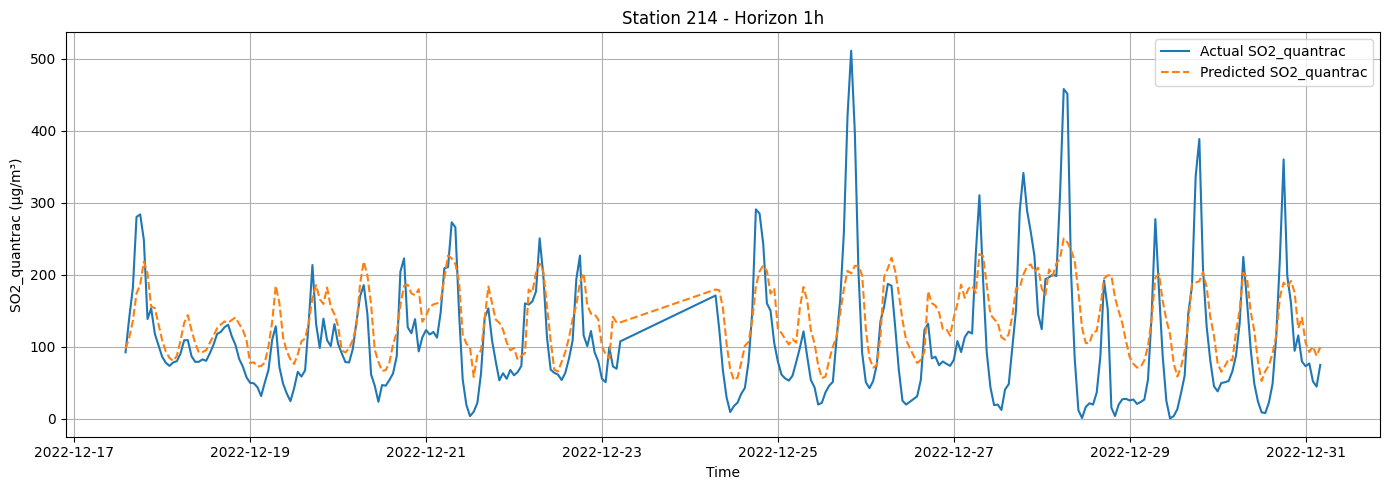

hour = 24
X_test_sid.shape: (712, 74)
y_test_sid.shape: (712, 1)
y_pred_sid.shape: (712,)


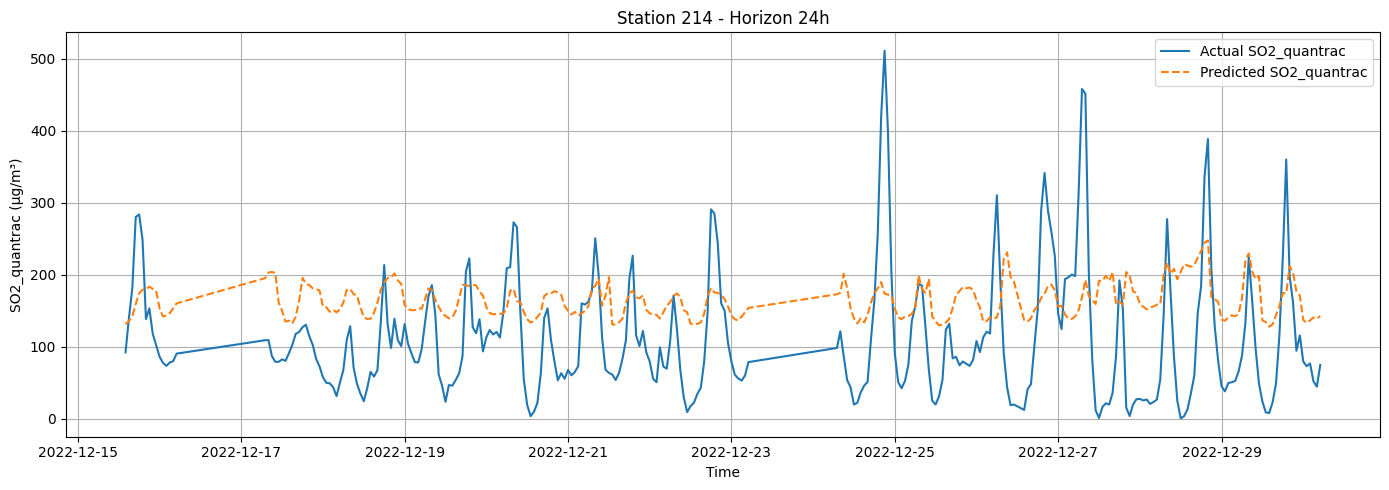

hour = 48
X_test_sid.shape: (709, 74)
y_test_sid.shape: (709, 1)
y_pred_sid.shape: (709,)


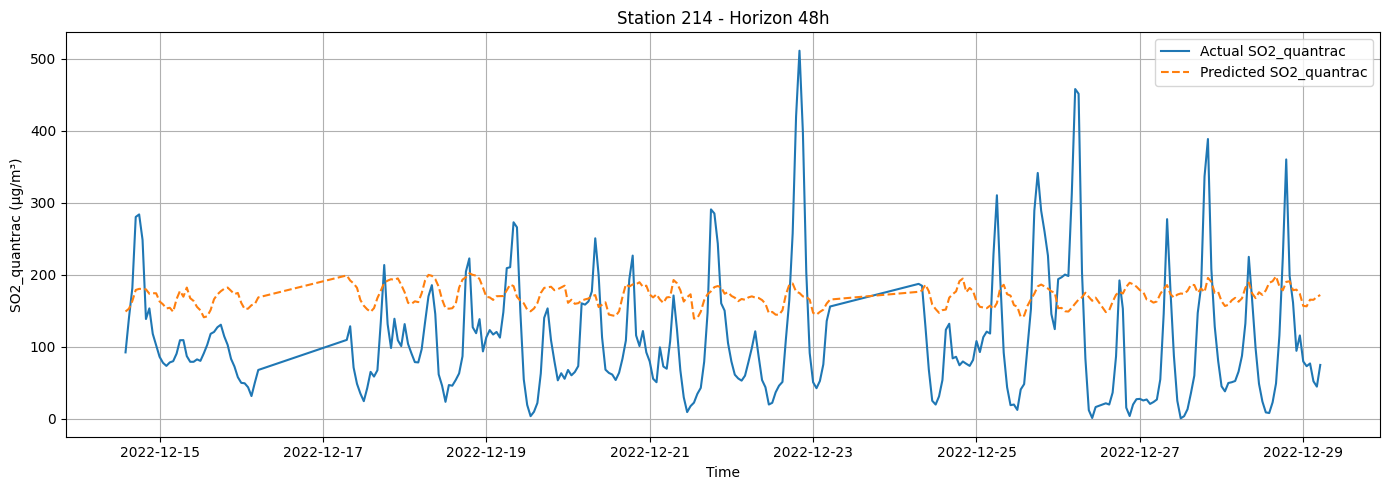

hour = 72
X_test_sid.shape: (705, 74)
y_test_sid.shape: (705, 1)
y_pred_sid.shape: (705,)


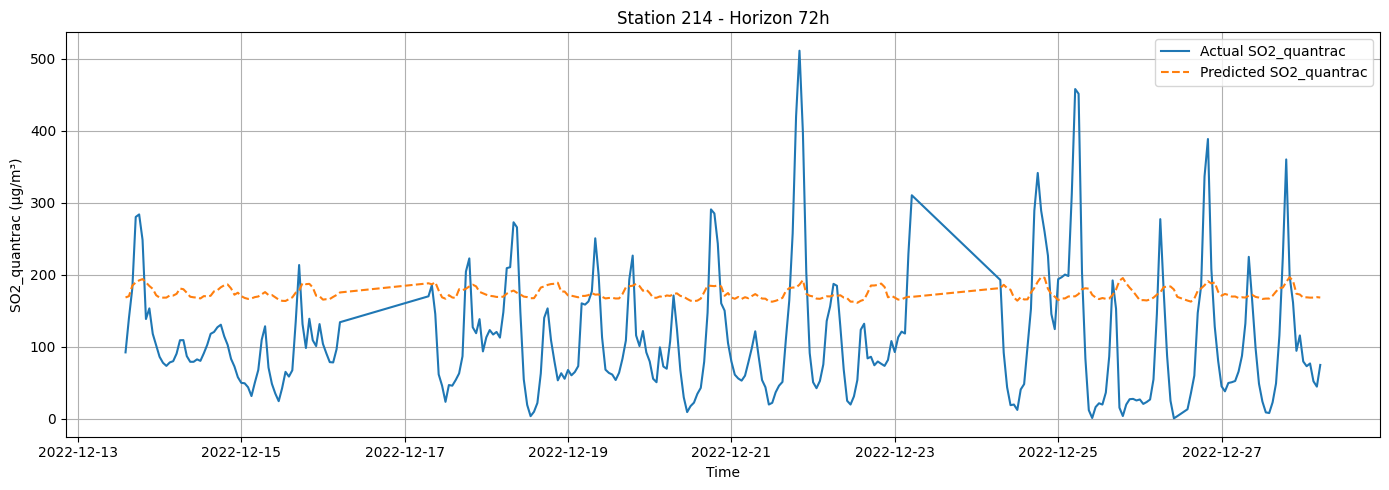

station_id = 216
hour = 1
X_test_sid.shape: (962, 74)
y_test_sid.shape: (962, 1)
y_pred_sid.shape: (962,)


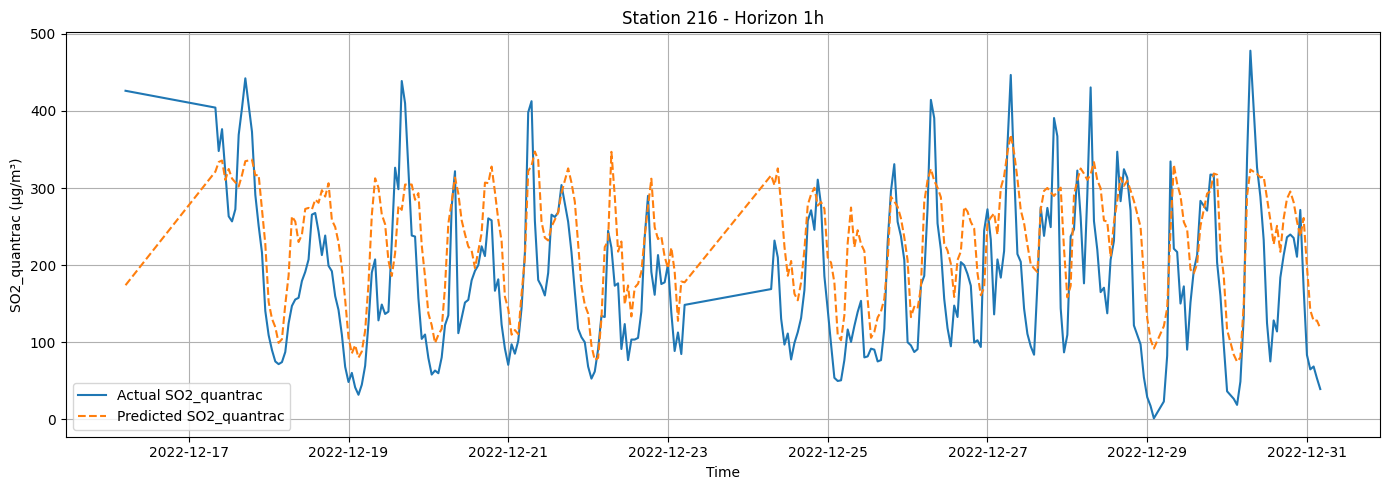

hour = 24
X_test_sid.shape: (958, 74)
y_test_sid.shape: (958, 1)
y_pred_sid.shape: (958,)


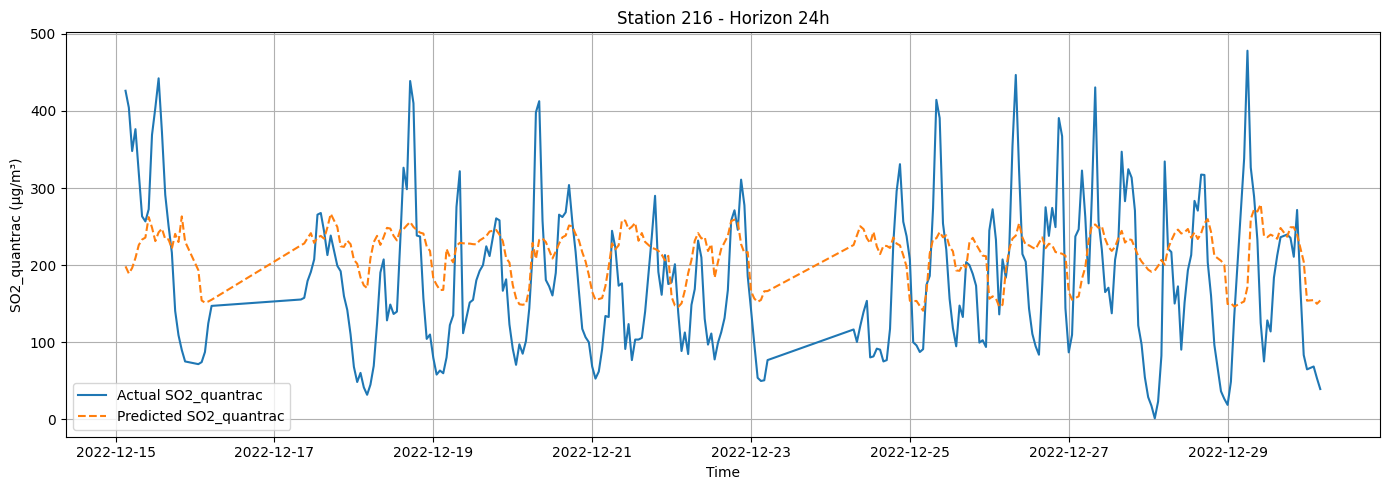

hour = 48
X_test_sid.shape: (955, 74)
y_test_sid.shape: (955, 1)
y_pred_sid.shape: (955,)


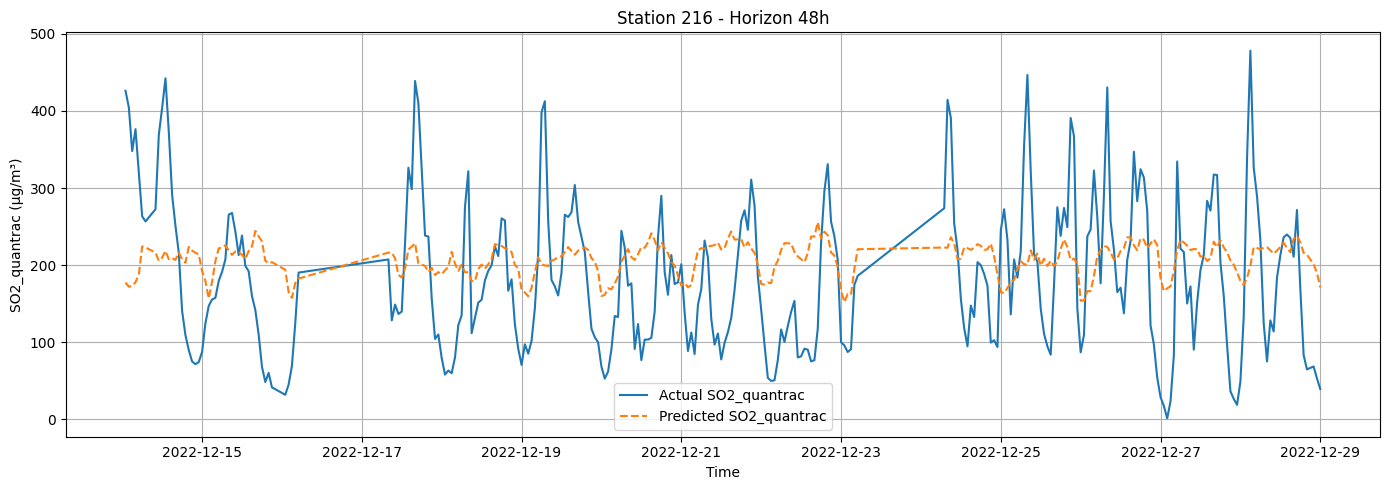

hour = 72
X_test_sid.shape: (951, 74)
y_test_sid.shape: (951, 1)
y_pred_sid.shape: (951,)


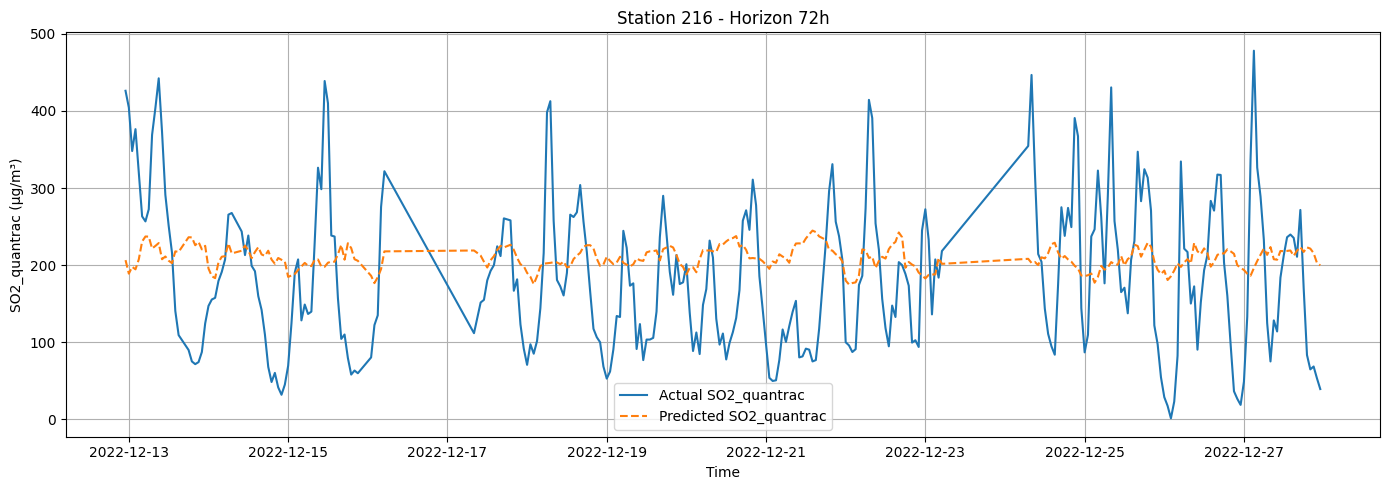

In [20]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_so2, so2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label, LIGHTGBM_DIR=LIGHTGBM_DIR)